# Read phytoplankton data and add functional group info

In [2]:
library(tidyverse, warn.conflicts = FALSE)
library(cowplot, warn.conflicts = FALSE)
library(scales, warn.conflicts = FALSE)

# library to read matlab data formats into R
library(reshape2)
library(lubridate)
library(vegan)

In [3]:
#library(worrms)

In [4]:
ds <- read.csv("../../DATA/Phytoplankton_newest_full.csv")

ds$Datetime_UTC = parse_date_time(ds$Datetime_UTC, orders = "%Y-%m-%d H:M:S")
ds$Datetime_local = parse_date_time(ds$Datetime_local, orders = "%Y-%m-%d H:M:S")

ds$date = ds$Datetime_UTC

## now read Functional Group annotated csv

In [5]:
annotated_fg <- read.csv("../../annotatedDATA/worms_dat_annotated_OLDFUNCGROUP.csv", sep=";", dec=',', stringsAsFactor=FALSE)
#annotated_fg = annotated_fg[complete.cases(annotated_fg),]

# trim dataframe to relevant columns
AphiaID2FG <- data.frame("AphiaID" = annotated_fg$AphiaID, 
                         "FuncGroup" = as.character(annotated_fg$functionalgroup_old), 
                         stringsAsFactors=FALSE)

In [39]:
test_size = read.csv("../../microscopy2size/first_test_cellmasses_andrew.csv")
names(test_size)[2] <- 'scientificname'
FG_sizes = merge(annotated_fg, test_size, by='scientificname')
FG_sizes$cellmass = 10^FG_sizes$log10cellmass # µg C cell^-1

In [57]:
AphiaID2Size <- data.frame("AphiaID" = FG_sizes$AphiaID, 
                           "FuncGroup" = as.character(FG_sizes$functionalgroup_old), 
                           "cellmass" = FG_sizes$cellmass,
                         stringsAsFactors=FALSE)

#check size data
ds_Size <- merge(ds, AphiaID2Size)

In [84]:
#AphiaID2Size

Warning message:
“Transformation introduced infinite values in continuous y-axis”


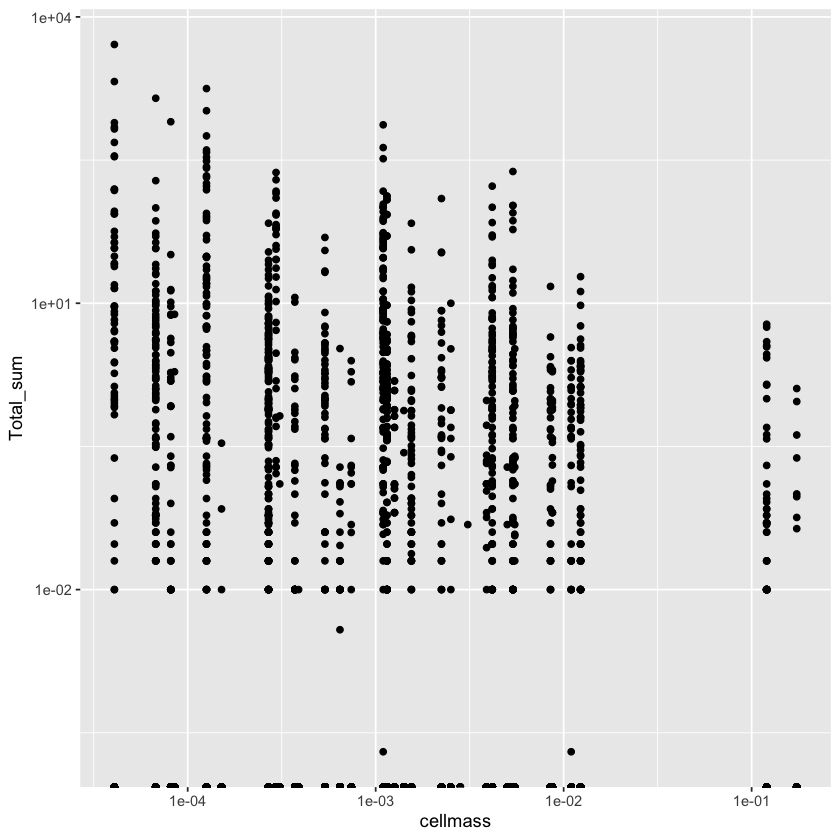

In [62]:
ggplot(data=ds_Size) + geom_point(aes(x=cellmass, y=Total_sum)) + scale_y_log10() + scale_x_log10()

In [112]:
large = ds_Size_year[ds_Size_year$cellmass>mean(ds_Size_year$cellmass),]
small = ds_Size_year[ds_Size_year$cellmass<mean(ds_Size_year$cellmass),]

Warning message:
“Transformation introduced infinite values in continuous y-axis”
Warning message:
“Removed 894 rows containing non-finite values (stat_boxplot).”
Warning message:
“Transformation introduced infinite values in continuous y-axis”
Warning message:
“Removed 7638 rows containing non-finite values (stat_boxplot).”


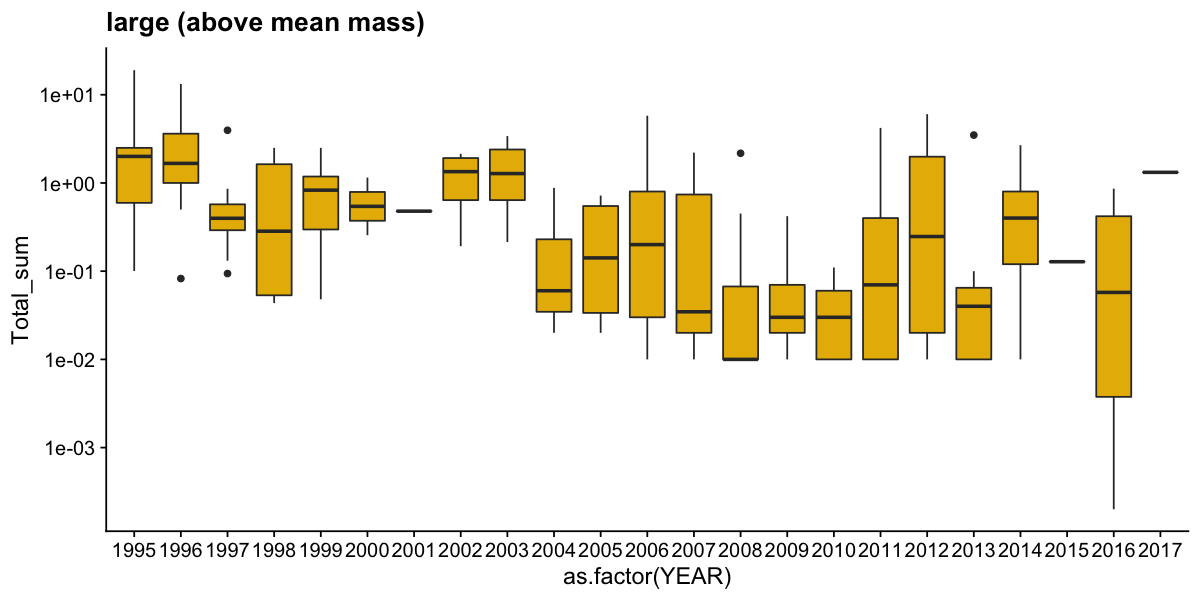

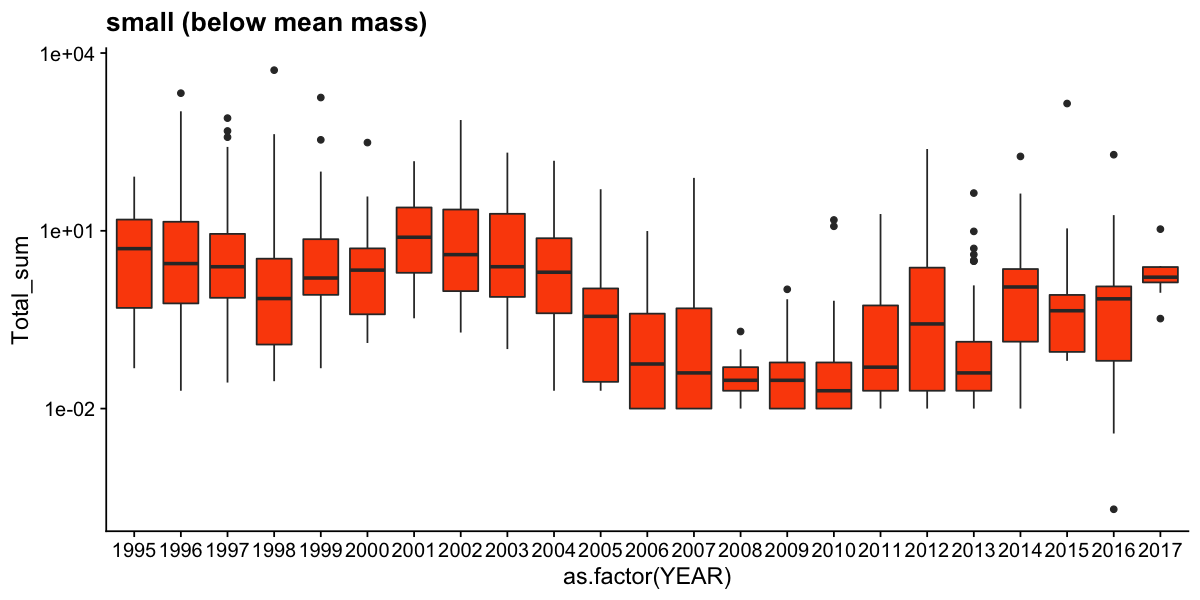

In [113]:
ggplot(data=large) + geom_boxplot(aes(x=as.factor(YEAR), y=Total_sum), fill="#E7B800") + 
    scale_y_log10() +theme_cowplot() + ggtitle("large (above mean mass)")
ggplot(data=small) + geom_boxplot(aes(x=as.factor(YEAR), y=Total_sum), fill="#FC4E07") + 
    scale_y_log10() +theme_cowplot()+ ggtitle("small (below mean mass)")


Warning message:
“Transformation introduced infinite values in continuous y-axis”
Warning message:
“Removed 8532 rows containing non-finite values (stat_boxplot).”


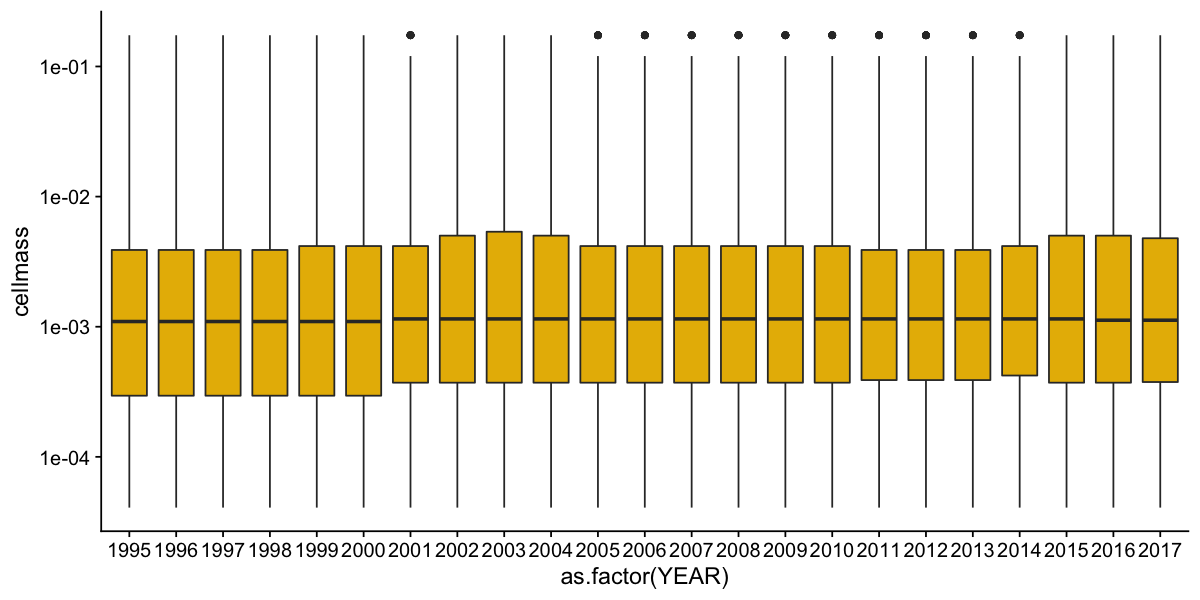

Warning message:
“Transformation introduced infinite values in continuous y-axis”
Warning message:
“Removed 8532 rows containing non-finite values (stat_boxplot).”


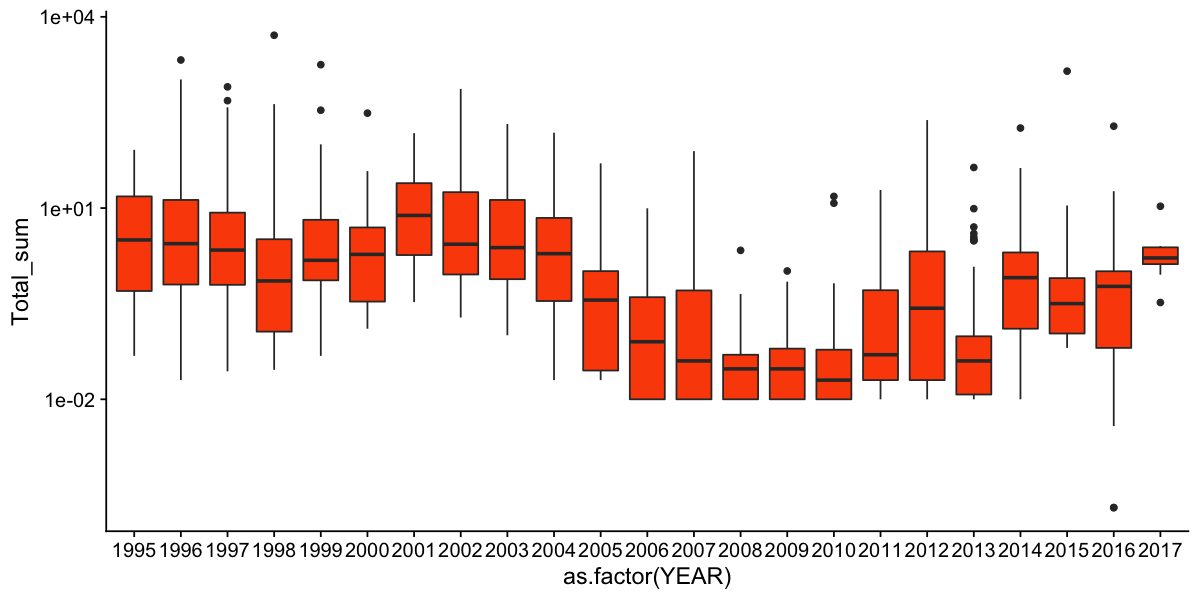

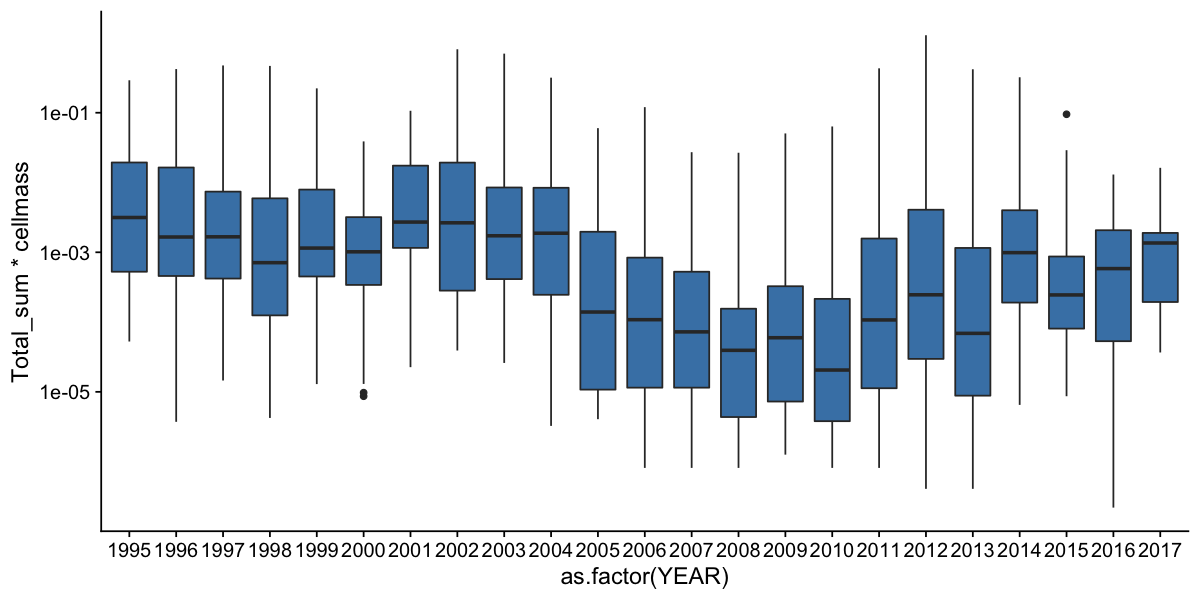

In [106]:
ds_Size_year <- ds_Size %>%
    mutate(YEAR = year(date), MONTH=month(date) ,DOY=yday(date))

options(repr.plot.width=10, repr.plot.height=5)
ggplot(data=ds_Size_year) + geom_boxplot(aes(x=as.factor(YEAR), y=cellmass), fill="#E7B800") + scale_y_log10() +theme_cowplot()

ggplot(data=ds_Size_year) + geom_boxplot(aes(x=as.factor(YEAR), y=Total_sum), fill="#FC4E07") + scale_y_log10() +theme_cowplot()

ggplot(data=ds_Size_year) + geom_boxplot(aes(x=as.factor(YEAR), y=Total_sum*cellmass), fill='steelblue') + scale_y_log10() +theme_cowplot()


## and merge with ds by AphiaID

In [116]:
ds_FG <- merge(ds, AphiaID2FG, all=TRUE)

In [117]:
ds_FG$FuncGroup[ds_FG$ScientificName_accepted == "nanoflagellates"]   <- "NANOFLAGELLATES"
ds_FG$FuncGroup[ds_FG$ScientificName_accepted == "palmelloid colony"] <- "PALMELLOIDCOLONY"

ds_FG_cleaned = ds_FG[!is.na(ds_FG$FuncGroup),]
ds_FG_cleaned = ds_FG_cleaned[order(ds_FG_cleaned$unlimited),]

# plot inter annual variability!

# NOW lets calculate some diversity metrics! with ds_FG_cleaned
start with Total_sum, and only later do depth integration

## -> need to flip the dataframe to have species as columns and abundances as rows!

to calcualte:
- number of species per day / year


In [118]:
#tail(ds_FG_cleaned[ds_FG_cleaned$ScientificName_accepted=="Akashiwo sanguinea",], n=50)

In [119]:
ds_wide <- ds_FG_cleaned %>%
    select(date, ScientificName_accepted, Total_sum) %>% 
    drop_na(date) %>%
    mutate(row = row_number()) %>%
    pivot_wider(names_from=ScientificName_accepted, values_from=Total_sum, id_cols=date, values_fill = NA, values_fn={mean}) 

ds_wide[is.na(ds_wide)] <- 0.0

In [120]:
#ds_wide

# TODO:
- calculate shannon (or other metric) per func group (monthly/yearly)
- calculate bray curtis (monthly/yearly) and show as colormap
- check andrew's list of species against CARIACOs species counts
- calculate some metric of variability within and between years
- (Ekman Transport?)

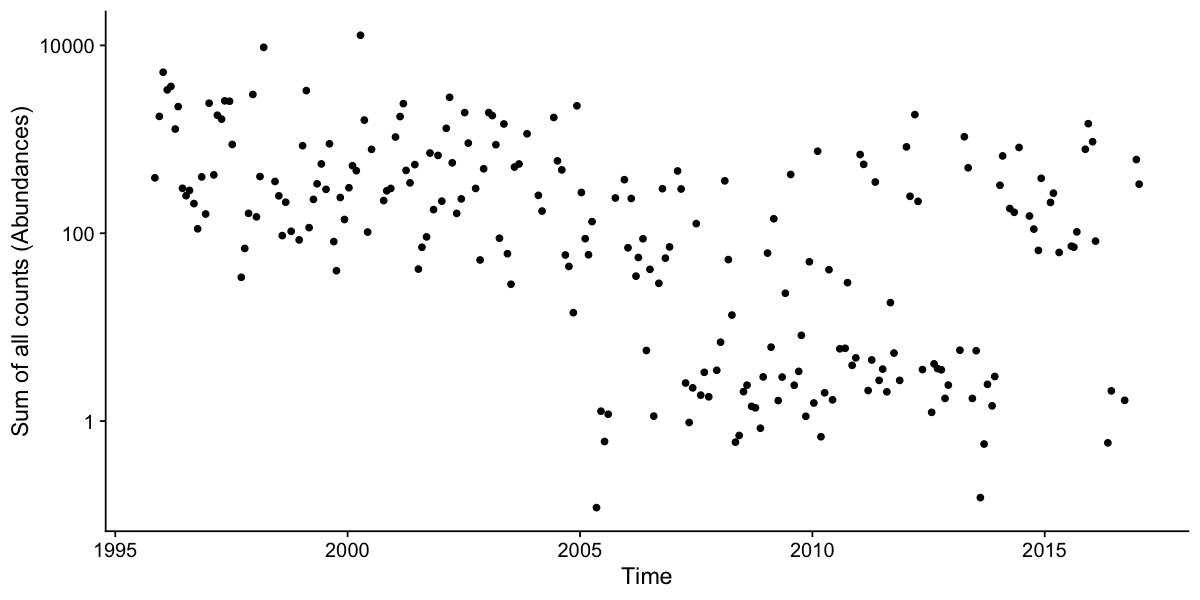

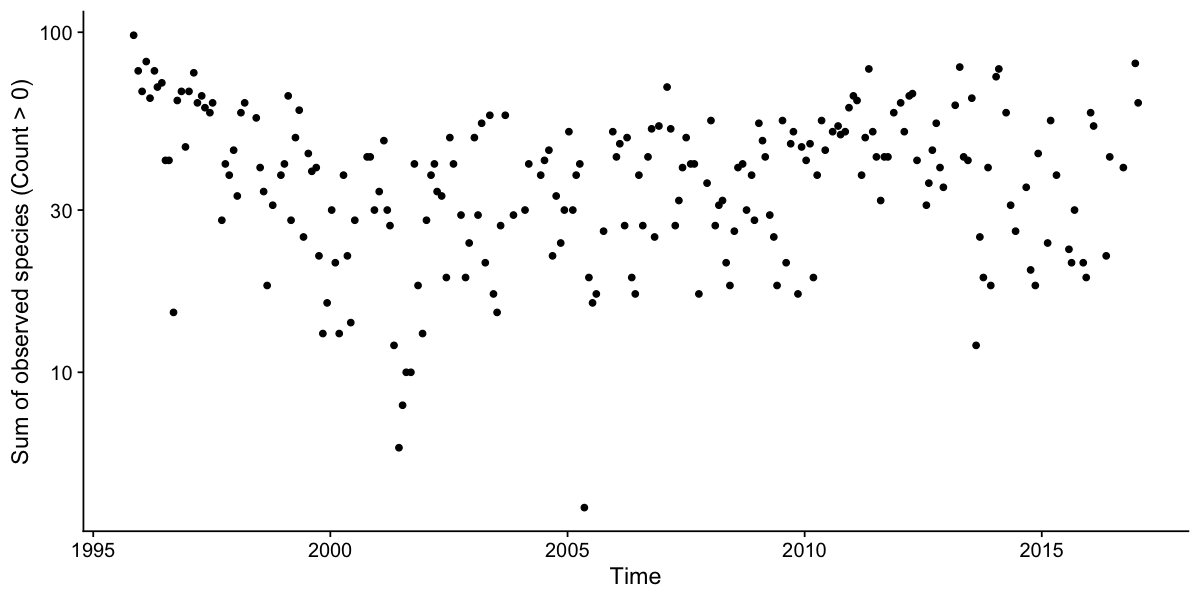

In [121]:
ds_wide_sums <- ds_wide %>%
    select(-date,-nanoflagellates , -`palmelloid colony`) %>%
     mutate(rowsum = rowSums(.), rowvals = rowSums(. > 0), date=ds_wide$date)

options(repr.plot.width=10, repr.plot.height=5)

ggplot(data=ds_wide_sums) + geom_point(aes(x = date, y = rowsum)) + theme_cowplot() + 
    ylab("Sum of all counts (Abundances)") + xlab("Time") + scale_y_log10()
      #scale_x_date(date_breaks = "years" , date_labels = "%y")


#ggsave("YEARsum_ShannonTimeSeries_DIATOMS.png", width=10, height=5)

ggplot(data=ds_wide_sums) + geom_point(aes(x = date, y = rowvals)) + theme_cowplot() + 
    ylab("Sum of observed species (Count > 0)") + xlab("Time") + scale_y_log10()

In [156]:
shannon_div_timemonth <- ds_wide %>%
    select(-date, -nanoflagellates , -`palmelloid colony`) %>%
    #diversity()
    summarize(tot_abundance = rowSums(.), spec_richness = rowSums(. > 0),date=ds_wide$date, diversity = diversity(.) ) %>%
    mutate(time_month = format(date, format = "%m-%Y"))

write.csv(shannon_div_timemonth, "shannon_div_excl_nano_palm.csv")

In [158]:
extractFG_DIV <- function(functype) {
ds <- ds_FG_cleaned %>%
    filter(FuncGroup == functype) %>%
    select(date, ScientificName_accepted, Total_sum) %>% 
    drop_na(date) %>%
    mutate(row = row_number()) %>%
    pivot_wider(names_from=ScientificName_accepted, values_from=Total_sum, id_cols=date, values_fill = NA, values_fn={mean}) 

ds[is.na(ds)] <- 0.0

ds_wide_sums <- ds %>%
    select(-date) %>%
    summarize(tot_abundance = rowSums(.), spec_richness = rowSums(. > 0),date=ds$date, diversity = diversity(.) ) %>%
    mutate(time_month = format(date, format = "%m-%Y"))
    
return(ds_wide_sums)
}


dia = extractFG_DIV("DIATOMS")
coc = extractFG_DIV("COCCOLITHOPHORIDS")
din = extractFG_DIV("DINOFLAGELLATES")
cya = extractFG_DIV("CYANOBACTERIA")
oth = extractFG_DIV("OTHERS")


write.csv(dia, "diatom_diversity.csv")
write.csv(coc, "cocco_diversity.csv")
write.csv(din, "dino_diversity.csv")
write.csv(cya, "cyano_diversity.csv")
write.csv(oth, "others_diversity.csv")

### now do the same per func group

In [122]:
unique(ds_FG_cleaned$FuncGroup)

[1] "COCCOLITHOPHORIDS" "DINOFLAGELLATES"   "DIATOMS"          
[4] "CYANOBACTERIA"     "OTHERS"            "NANOFLAGELLATES"  
[7] "PALMELLOIDCOLONY"

In [123]:
extractFG <- function(functype) {
ds <- ds_FG_cleaned %>%
    filter(FuncGroup == functype) %>%
    select(date, ScientificName_accepted, Total_sum) %>% 
    drop_na(date) %>%
    mutate(row = row_number()) %>%
    pivot_wider(names_from=ScientificName_accepted, values_from=Total_sum, id_cols=date, values_fill = NA, values_fn={mean}) 

ds[is.na(ds)] <- 0.0
    
return(ds)
}


# diatoms
diatoms_wide <- extractFG("DIATOMS")
# cocco
cocco_wide <- extractFG("COCCOLITHOPHORIDS")
# dino
dino_wide <- extractFG("DINOFLAGELLATES")
# cyano
cyano_wide <- extractFG("CYANOBACTERIA")
# others
others_wide <- extractFG("OTHERS")

In [168]:
plotTotAbundSpeciesRich <- function(dataset) {
 ds_wide_sums <- dataset %>%
    select(-date) %>%
    mutate(rowsum = rowSums(.), rowvals = rowSums(. > 0), date=dataset$date)%>%
    mutate(YEAR = year(date), MONTH=month(date) ,DOY=yday(date))
    
    plot1 <- ggplot(data=ds_wide_sums) + geom_point(aes(x = date, y = rowsum + 0.001), col='blue') + theme_cowplot() + 
        ylab("Sum of all counts (Abundances)") + xlab("Time") + ggtitle(deparse(substitute(dataset))) #+ scale_y_log10()
    
    plot2 <- ggplot(data=ds_wide_sums) + geom_point(aes(x = date, y = rowvals)) + theme_cowplot() + 
        ylab("Sum of observed species (Count > 0)") + xlab("Time") #+ scale_y_log10()
    
    plot3 <- ggplot(data=ds_wide_sums) + geom_boxplot(aes(x=as.factor(MONTH), y = rowsum), fill='steelblue') + 
        ylab("Sum of all counts LOG") + xlab("Time") + theme_cowplot() + scale_y_log10()
    
    p <- plot_grid(plot1, plot2, plot3, ncol=1, align='v')
    return(p)
    #ggdraw(p)+ draw_label(deparse(substitute(dataset)), 0.5,.94)
}


Warning message:
“Transformation introduced infinite values in continuous y-axis”
Warning message:
“Removed 1 rows containing non-finite values (stat_boxplot).”
Warning message:
“Transformation introduced infinite values in continuous y-axis”
Warning message:
“Removed 8 rows containing non-finite values (stat_boxplot).”


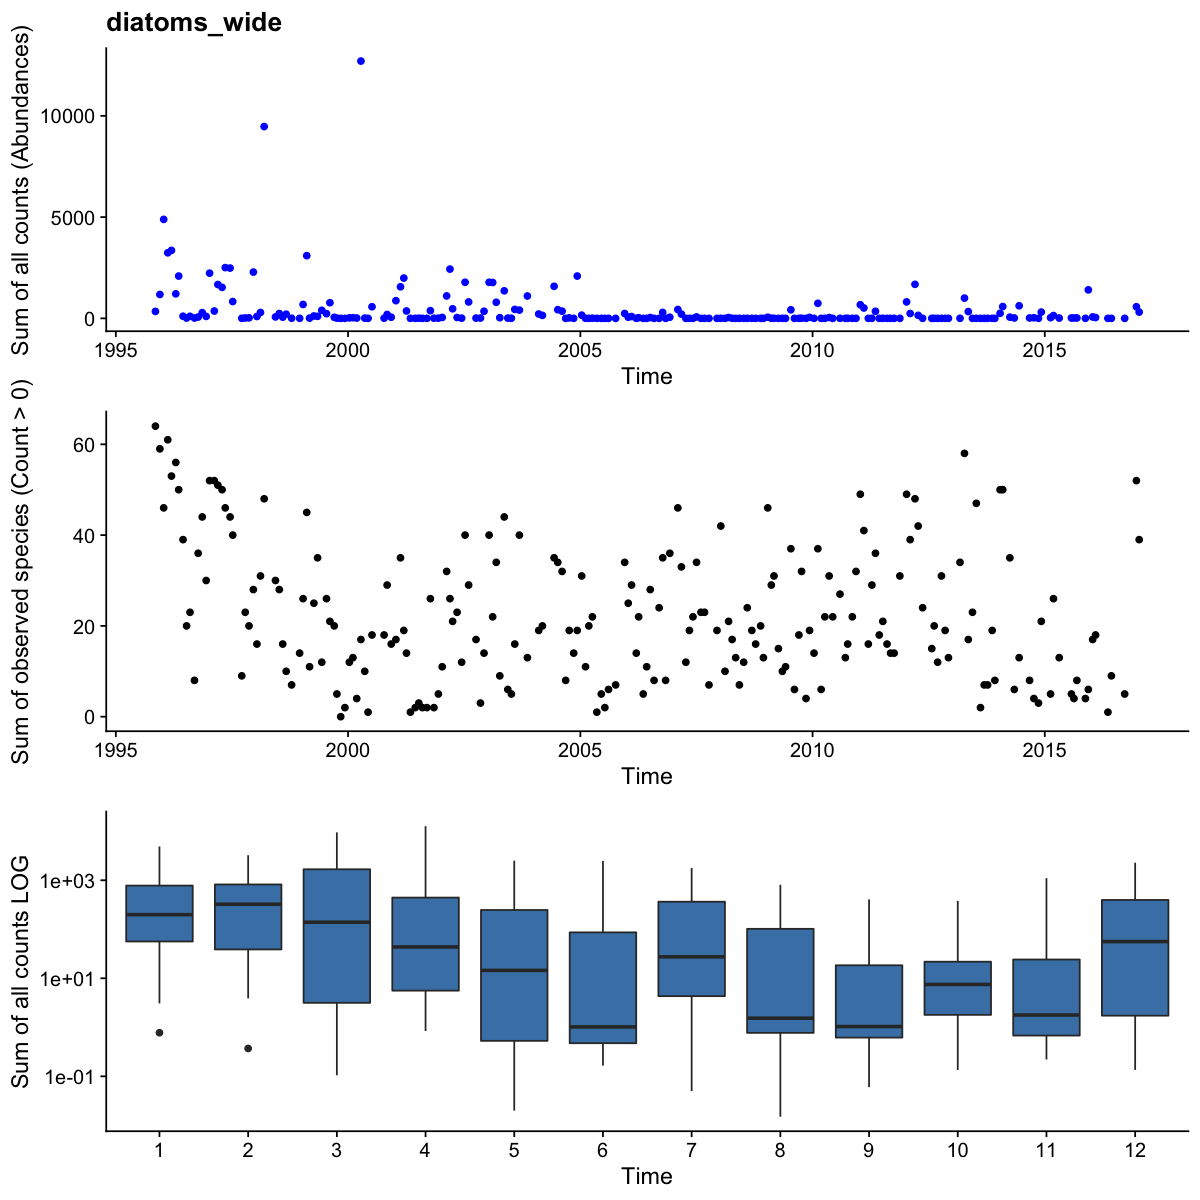

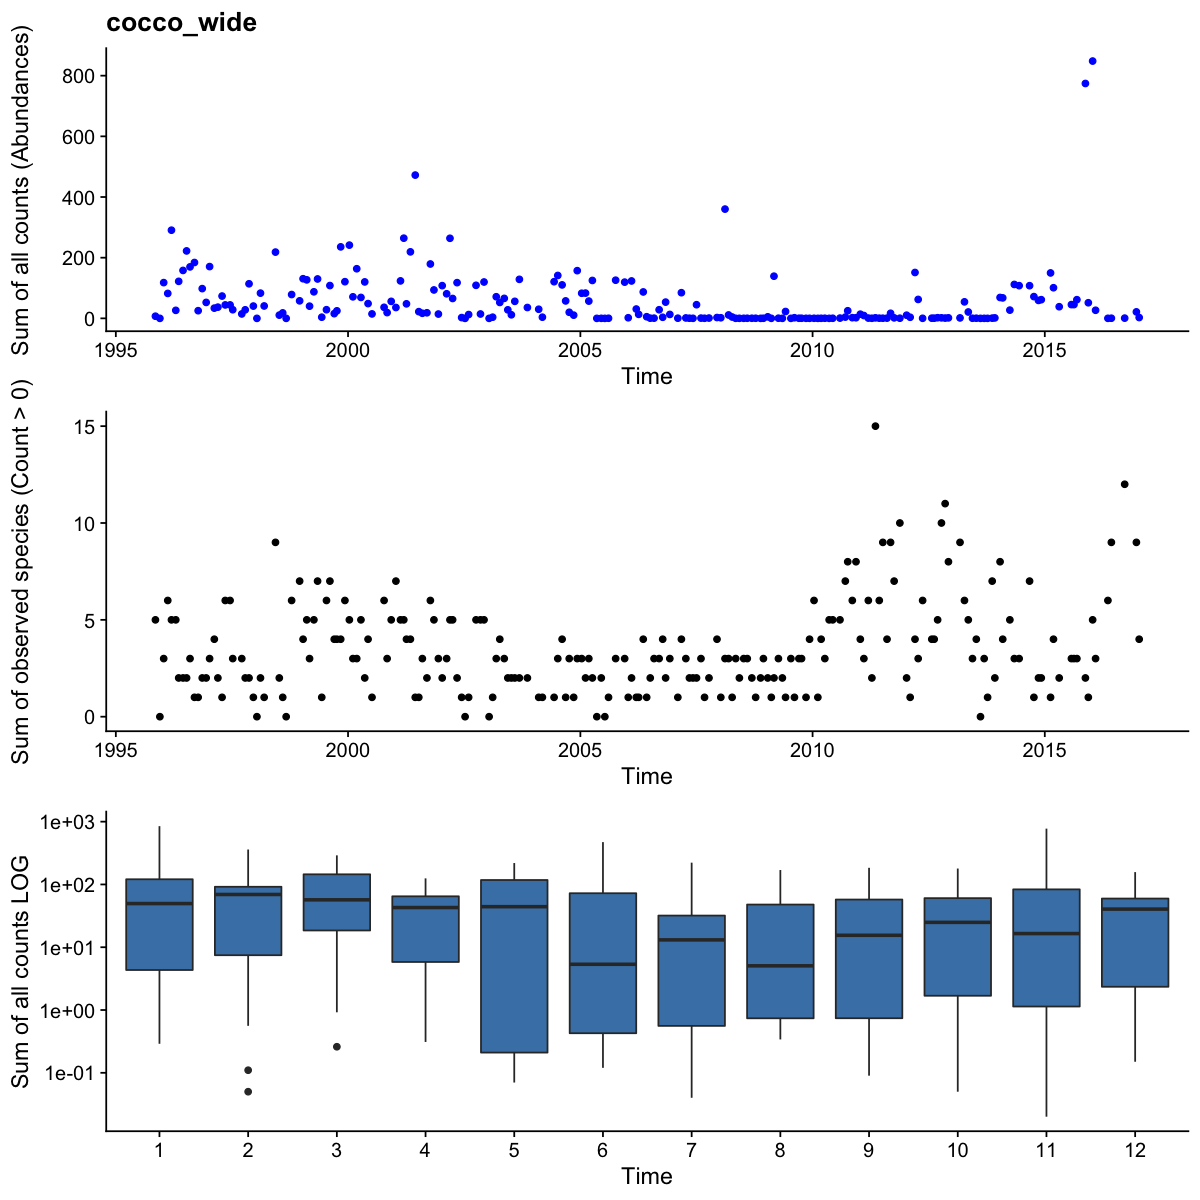

Warning message:
“Transformation introduced infinite values in continuous y-axis”
Warning message:
“Removed 49 rows containing non-finite values (stat_boxplot).”


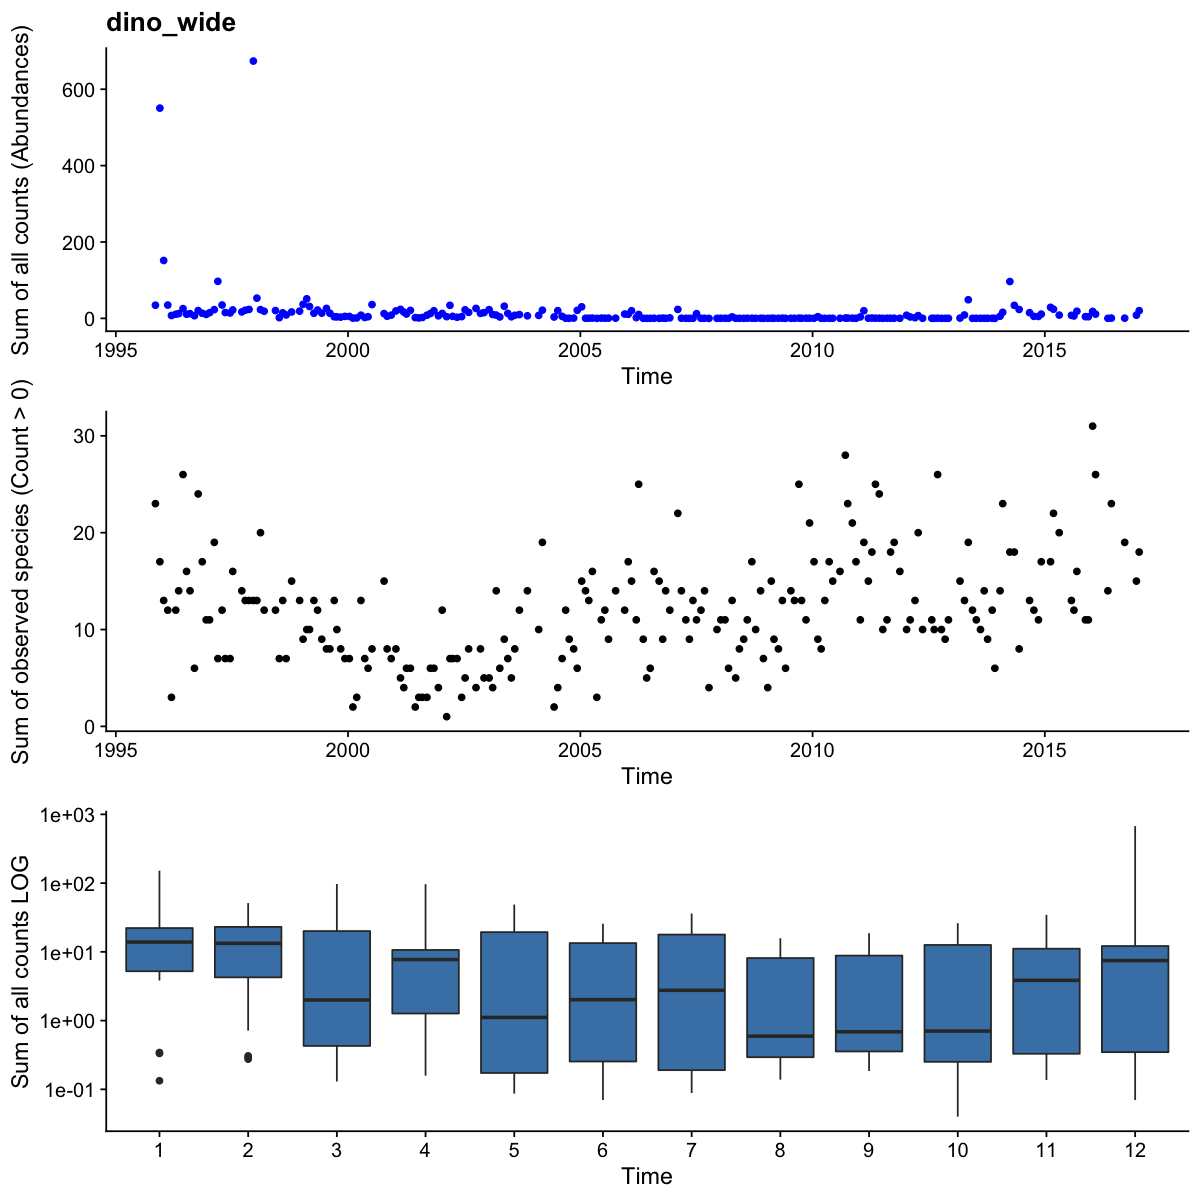

Warning message:
“Transformation introduced infinite values in continuous y-axis”
Warning message:
“Removed 74 rows containing non-finite values (stat_boxplot).”


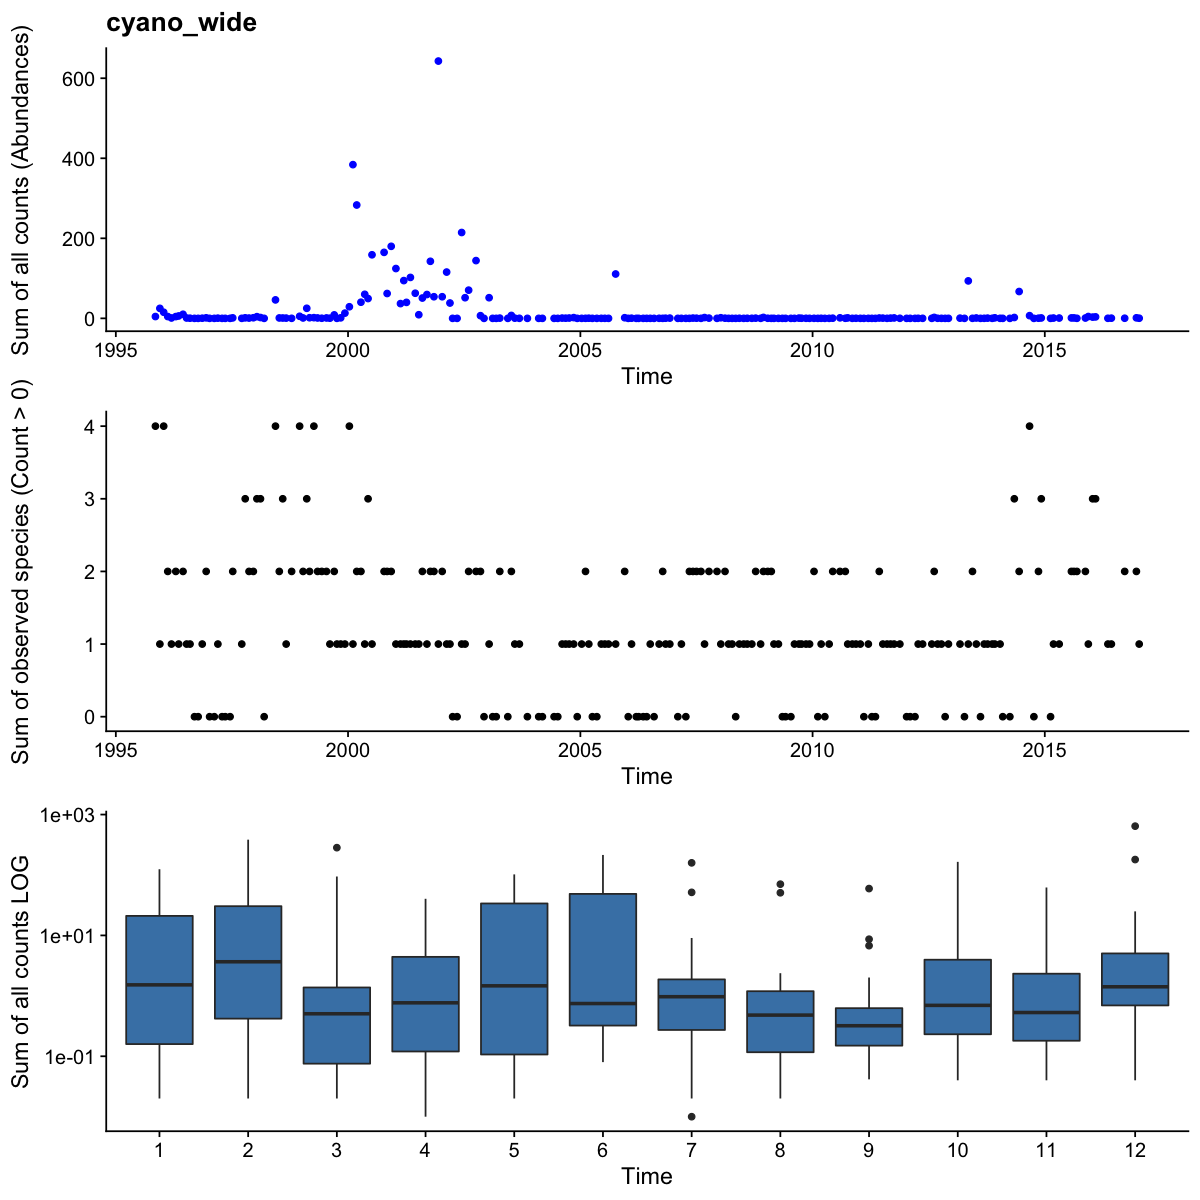

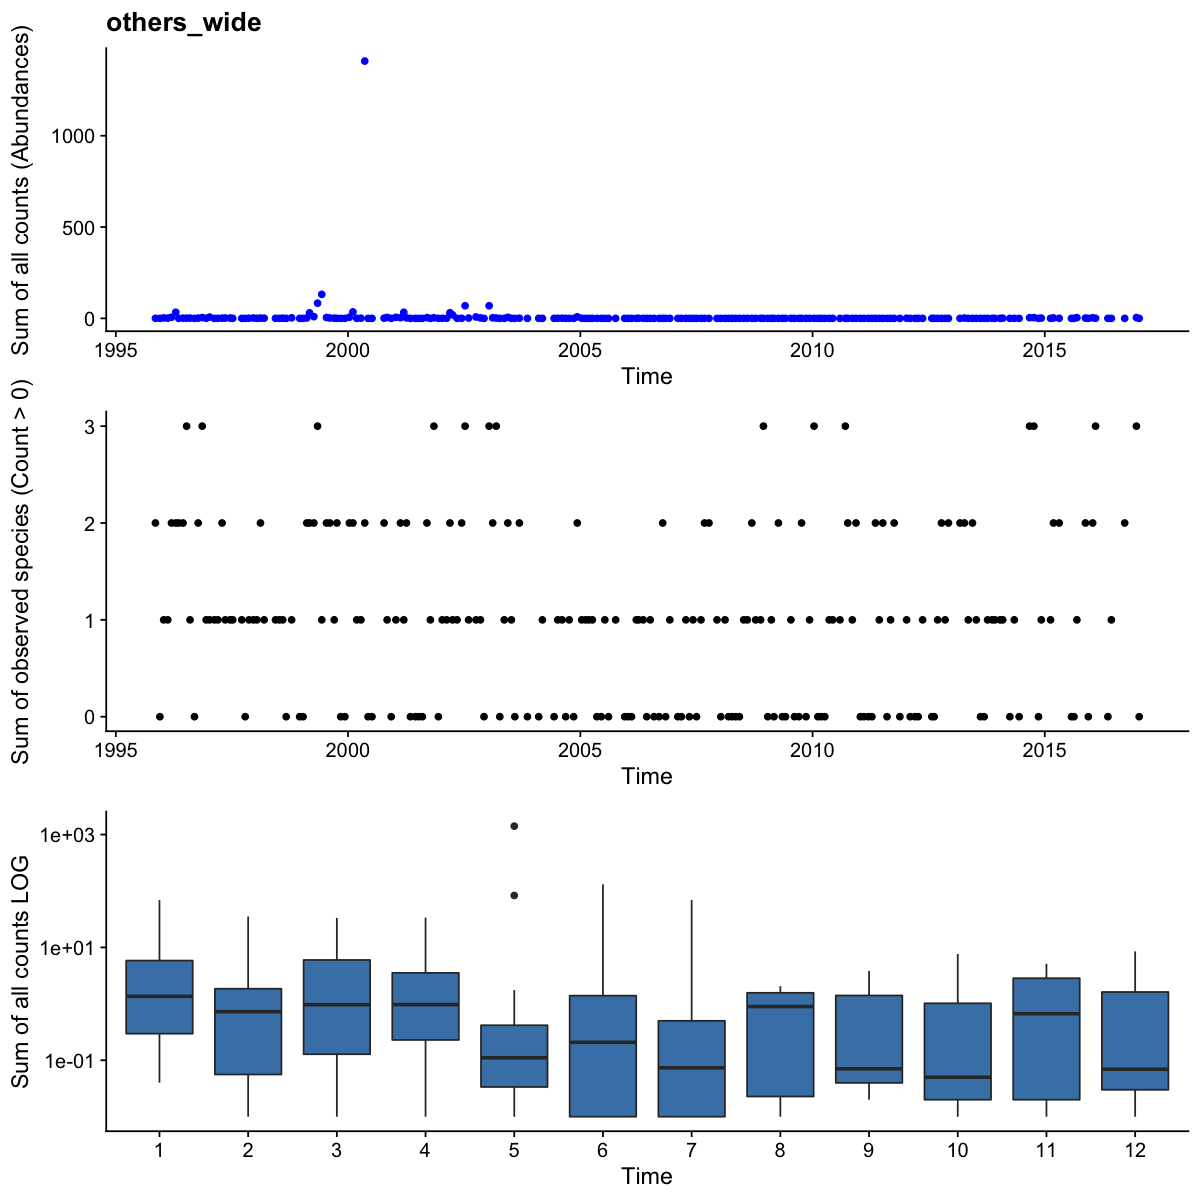

In [169]:
options(repr.plot.width=10, repr.plot.height=10)
plotTotAbundSpeciesRich(diatoms_wide)
plotTotAbundSpeciesRich(cocco_wide)
plotTotAbundSpeciesRich(dino_wide)
plotTotAbundSpeciesRich(cyano_wide)
plotTotAbundSpeciesRich(others_wide)

# shannon diversity

In [161]:
shannon_div_inclALL <- ds_wide %>%
    select(-date) %>% #, -nanoflagellates , -`palmelloid colony`) %>%
    #diversity()
    summarize(date=ds_wide$date, diversity = diversity(.)) %>%

    mutate(YEAR = year(date), MONTH=month(date) ,DOY=yday(date))

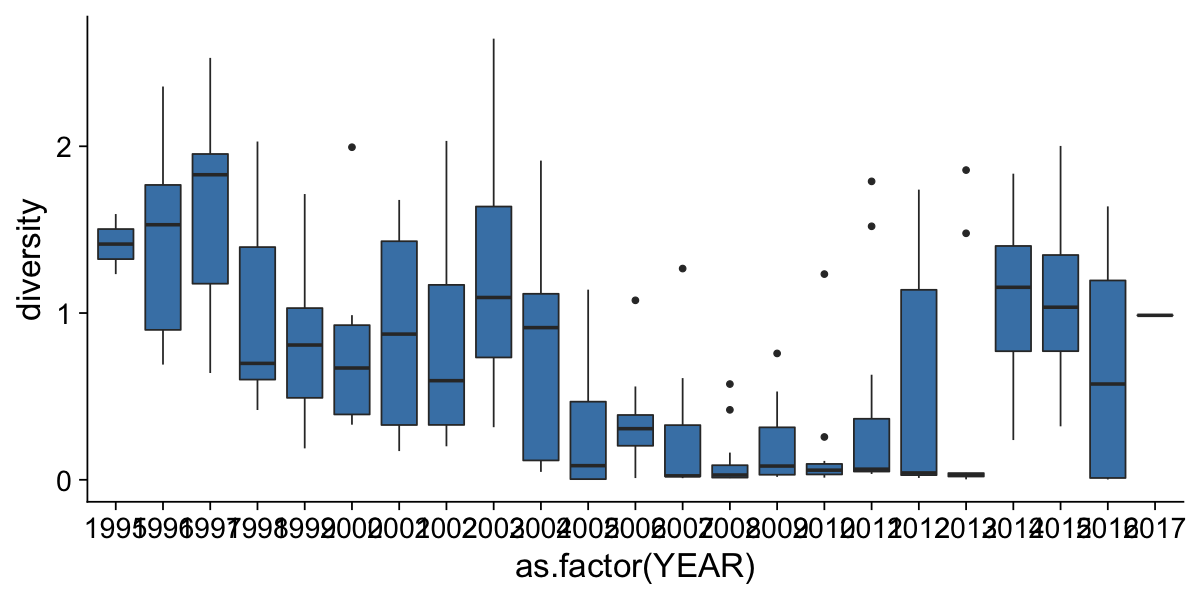

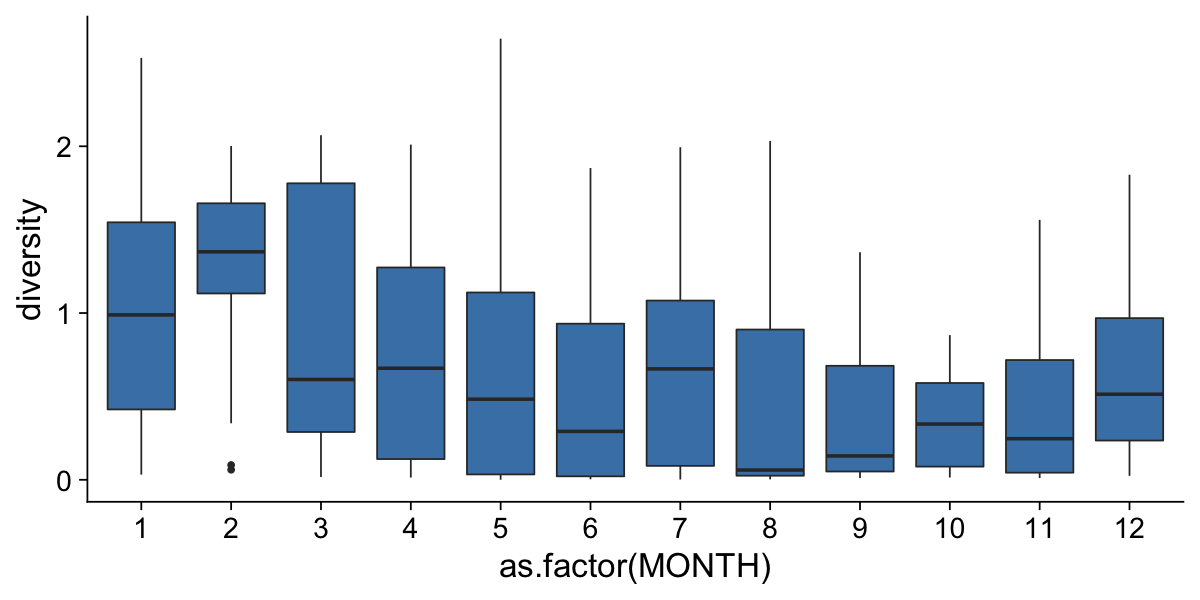

In [162]:
options(repr.plot.width=10, repr.plot.height=5)
ggplot(data=shannon_div_inclALL) + geom_boxplot(aes(x=as.factor(YEAR), y=diversity), fill='steelblue') + theme_cowplot(20)
ggplot(data=shannon_div_inclALL) + geom_boxplot(aes(x=as.factor(MONTH), y=diversity), fill='steelblue') + theme_cowplot(20)

In [163]:
shannon_div_timemonth <- ds_wide %>%
    select(-date, -nanoflagellates , -`palmelloid colony`) %>%
    #diversity()
    summarize(date=ds_wide$date, diversity = diversity(.)) %>%
    mutate(time_month = format(date, format = "%m-%Y"))

write.csv(shannon_div_timemonth, "shannon_div_excl_nano_palm.csv")

In [164]:
shannon_div <- ds_wide %>%
    select(-date, -nanoflagellates , -`palmelloid colony`) %>%
    #diversity()
    summarize(date=ds_wide$date, diversity = diversity(.)) %>%

    mutate(YEAR = year(date), MONTH=month(date) ,DOY=yday(date))

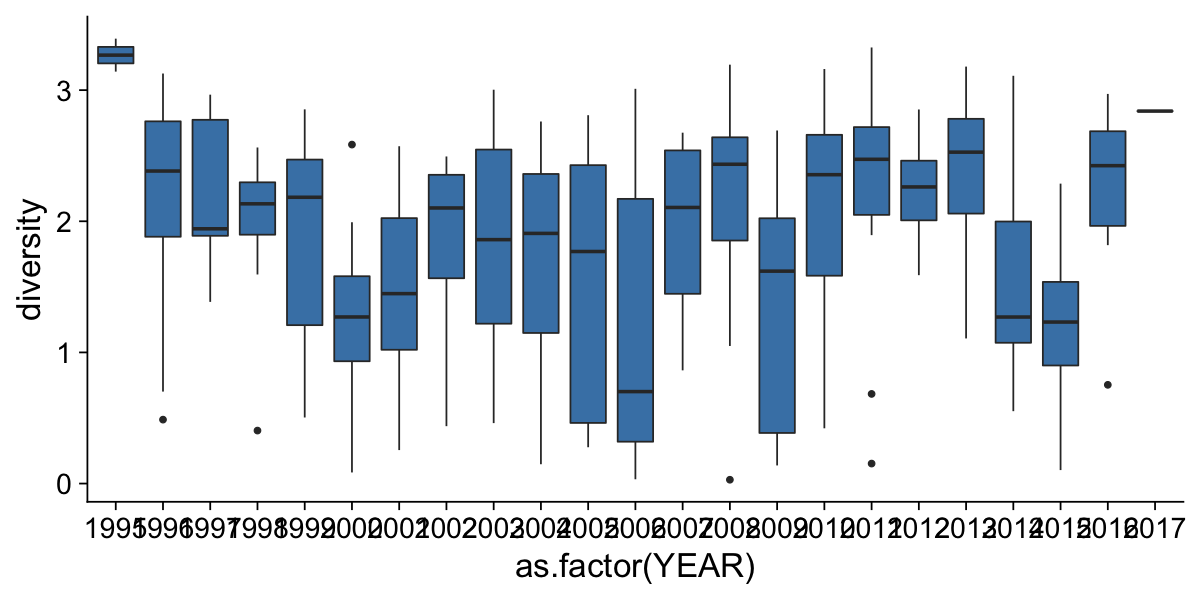

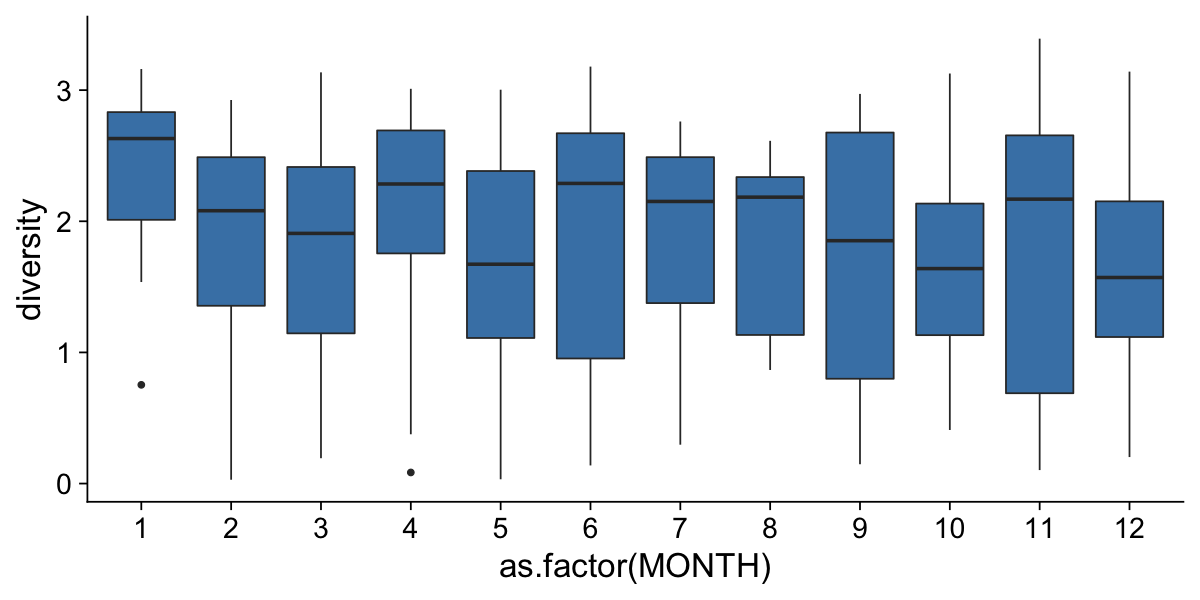

In [165]:
options(repr.plot.width=10, repr.plot.height=5)
ggplot(data=shannon_div) + geom_boxplot(aes(x=as.factor(YEAR), y=diversity), fill='steelblue') + theme_cowplot(20)
ggplot(data=shannon_div) + geom_boxplot(aes(x=as.factor(MONTH), y=diversity), fill='steelblue') + theme_cowplot(20)

In [194]:
calcdiv <- function(dataset) {

div <- dataset %>%
    select(-date) %>%
    #diversity()
    summarize(date=dataset$date, diversity = diversity(., index="shannon")) %>%
    mutate(YEAR = year(date), MONTH=month(date) ,DOY=yday(date))
    
ggplot(data=div) + geom_boxplot(aes(x=as.factor(YEAR), y=diversity), fill='steelblue') + theme_cowplot(20) + 
    ggtitle(deparse(substitute(dataset))) 
    
}

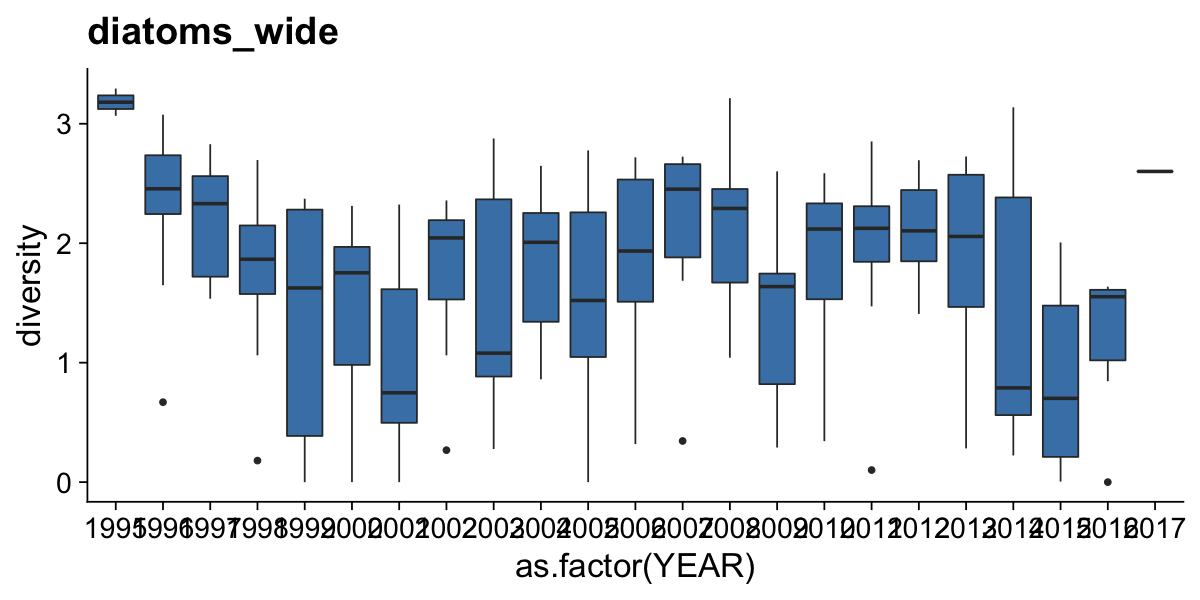

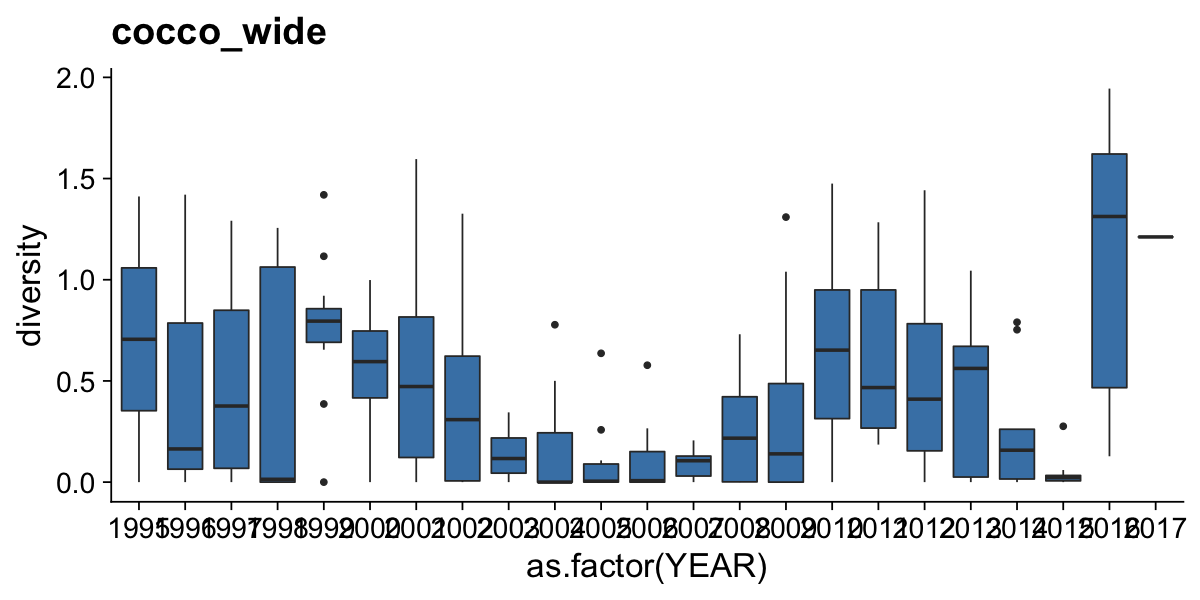

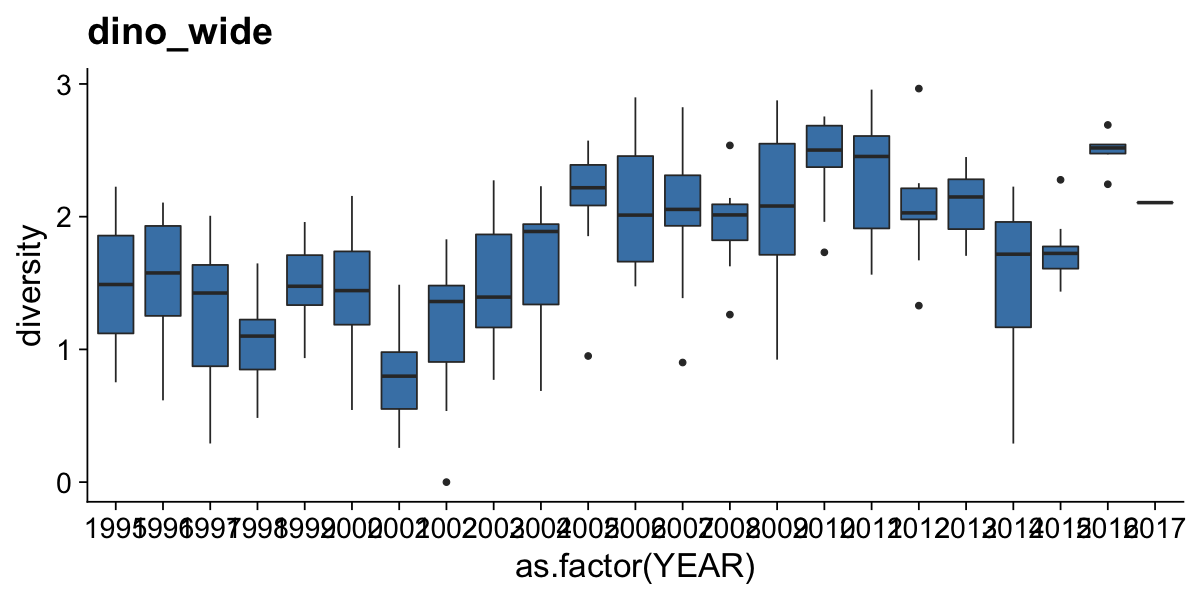

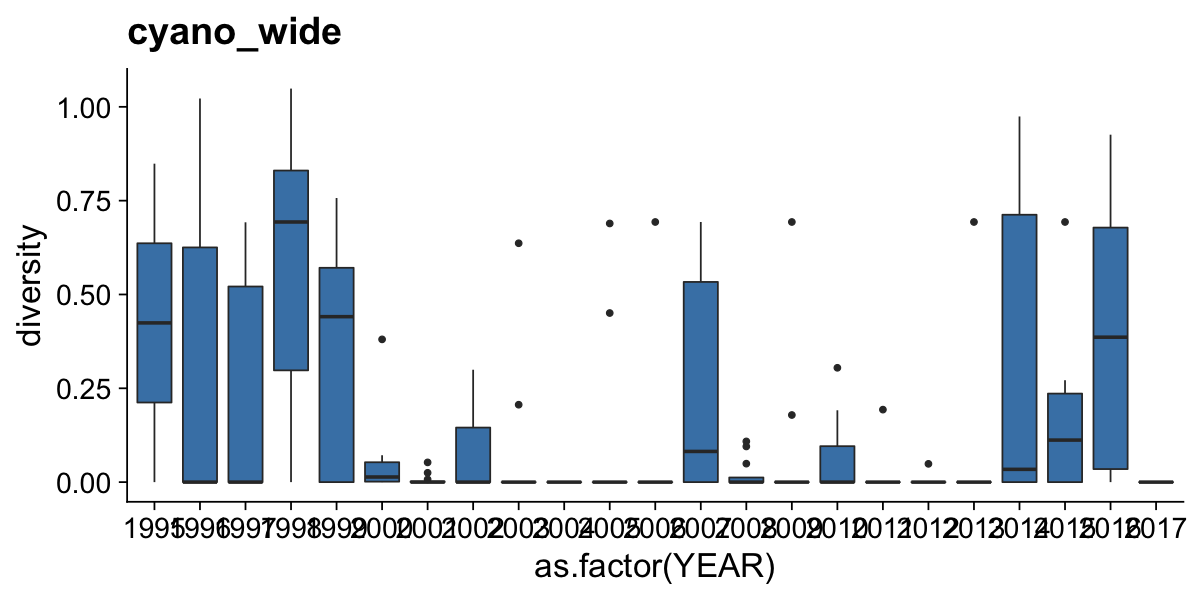

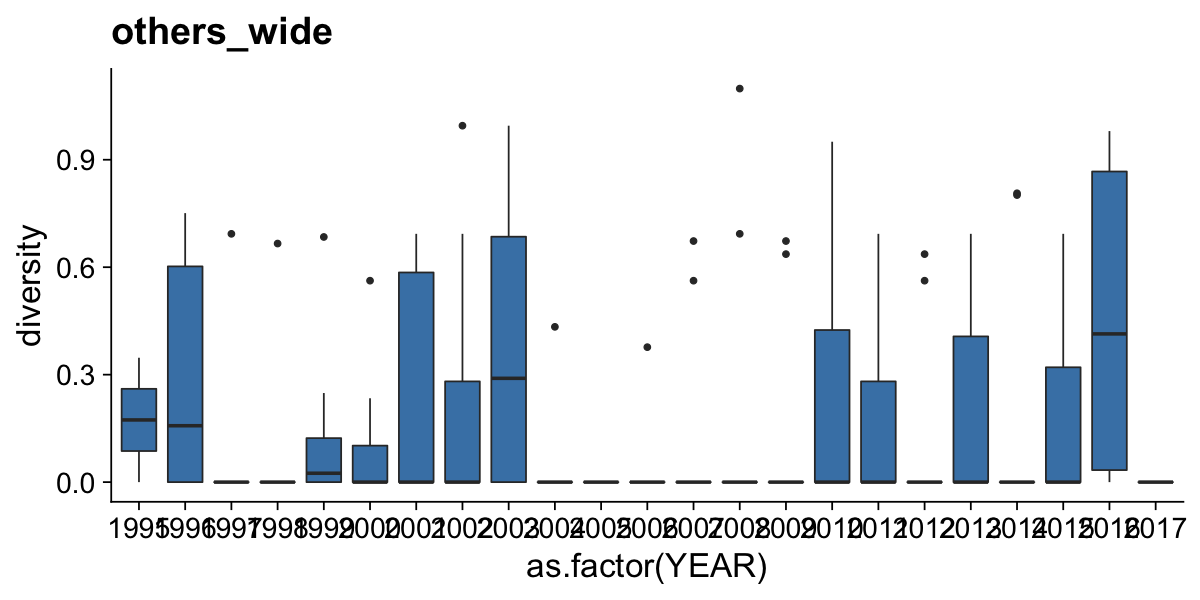

In [195]:
calcdiv(diatoms_wide)
calcdiv(cocco_wide)
calcdiv(dino_wide)
calcdiv(cyano_wide)
calcdiv(others_wide)

# BRAY CURTISSSSSS

[1] 0.4124294 0.4850299 0.4725275 0.4878049 0.4802260 0.4911243

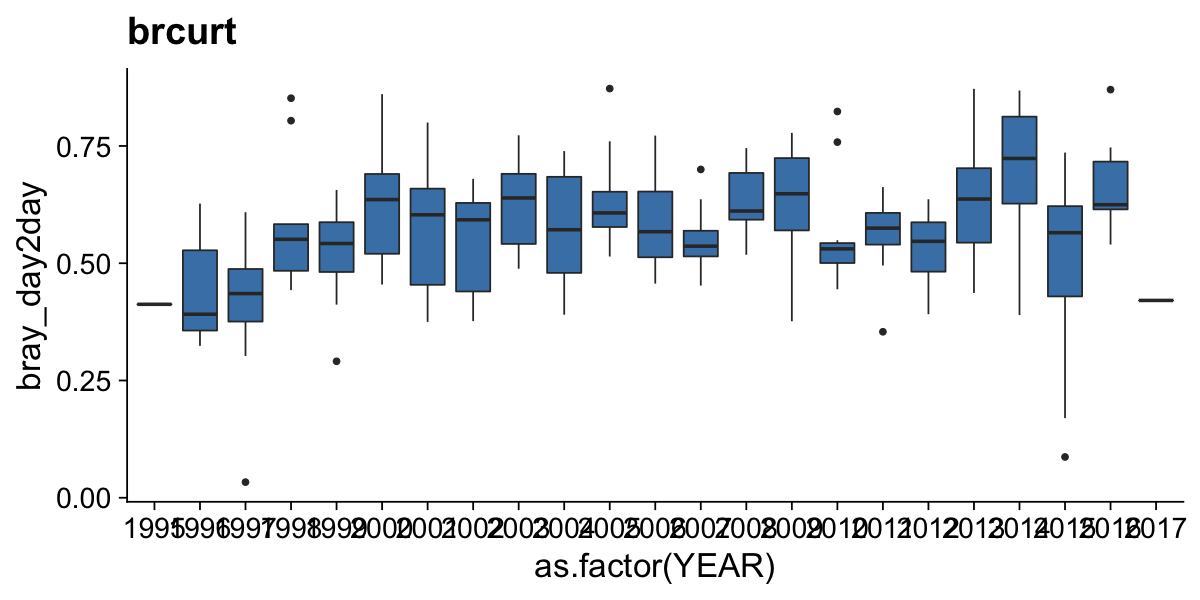

In [136]:
bray_curtis <- ds_wide %>%
    select(-date, -`palmelloid colony`) %>%
    #sqrt() %>%
    vegdist(method="bray", binary=TRUE)

head(bray_curtis)

subdiag <- function (dist_obj, d) {
  if (!inherits(dist_obj, "dist")) stop("please provide a 'dist' object!")
  n <- attr(dist_obj, "Size")
  if (d < 1 || d > (n - 1)) stop(sprintf("'d' needs be between 1 and %d", n - 1L))
  j_1 <- c(0, seq.int(from = n - 1, by = -1, length = n - d - 1))
  subdiag_ind <- d + cumsum(j_1)
  dist_obj[subdiag_ind]
  }

br_curt_d2d = data.frame(date = ds_wide$date[-1], bray_day2day = subdiag(bray_curtis, 1))

brcurt <- br_curt_d2d %>%
    mutate(YEAR = year(date), MONTH=month(date) ,DOY=yday(date))

ggplot(data=brcurt) + geom_boxplot(aes(x=as.factor(YEAR), y=bray_day2day), fill='steelblue') + theme_cowplot(20) + 
    ggtitle(deparse(substitute(brcurt))) 

In [283]:
ds_wide_yearsum <- ds_wide %>%
    select(-`palmelloid colony`) %>%
    mutate(date = as.Date(date)) %>%
    mutate(YEAR = year(date), DOY=yday(date)) %>%
    group_by(YEAR) %>% 
    select(-date) %>%
    summarize_all(sum) 

diatoms_yearsum <- diatoms_wide %>%
    mutate(date = as.Date(date)) %>%
    mutate(YEAR = year(date), DOY=yday(date)) %>%
    group_by(YEAR) %>% 
    select(-date) %>%
    summarize_all(sum) 

In [272]:
wide_brcrts <- ds_wide_yearsum %>%
    select(-YEAR) %>%
    sqrt() %>%
    vegdist(method="jaccard")#, binary=TRUE)

diatoms_brcrts <- diatoms_yearsum %>%
    select(-YEAR) %>%
    sqrt() %>%
    vegdist(method="jaccard")#, binary=TRUE)

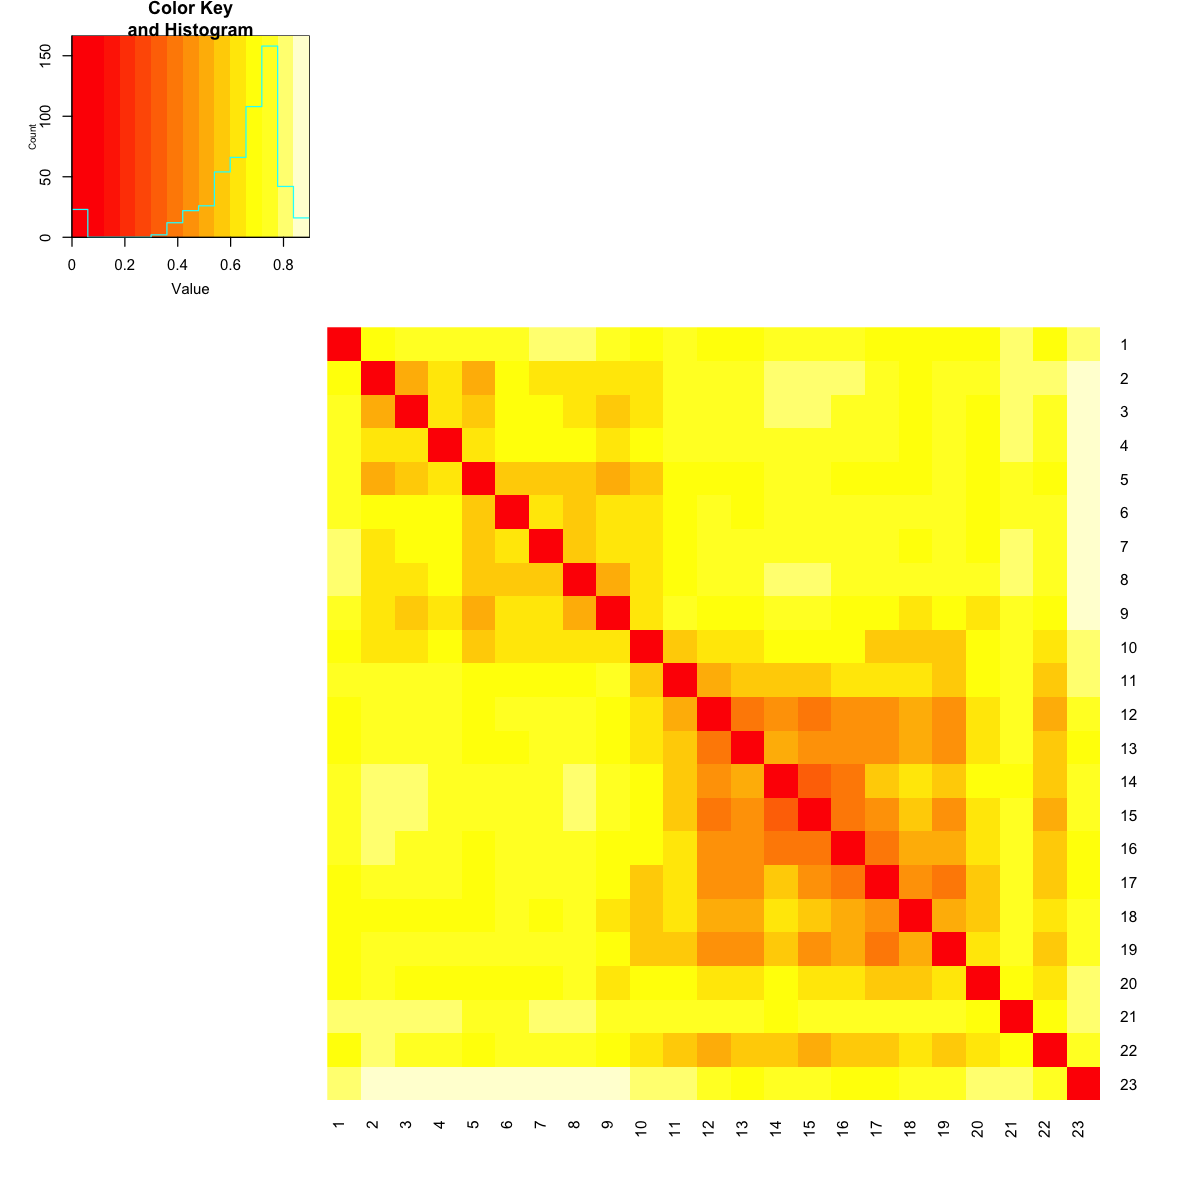

In [273]:
heatmap.2(as.matrix(wide_brcrts),dendrogram='none', Rowv=FALSE, Colv=FALSE,trace='none')

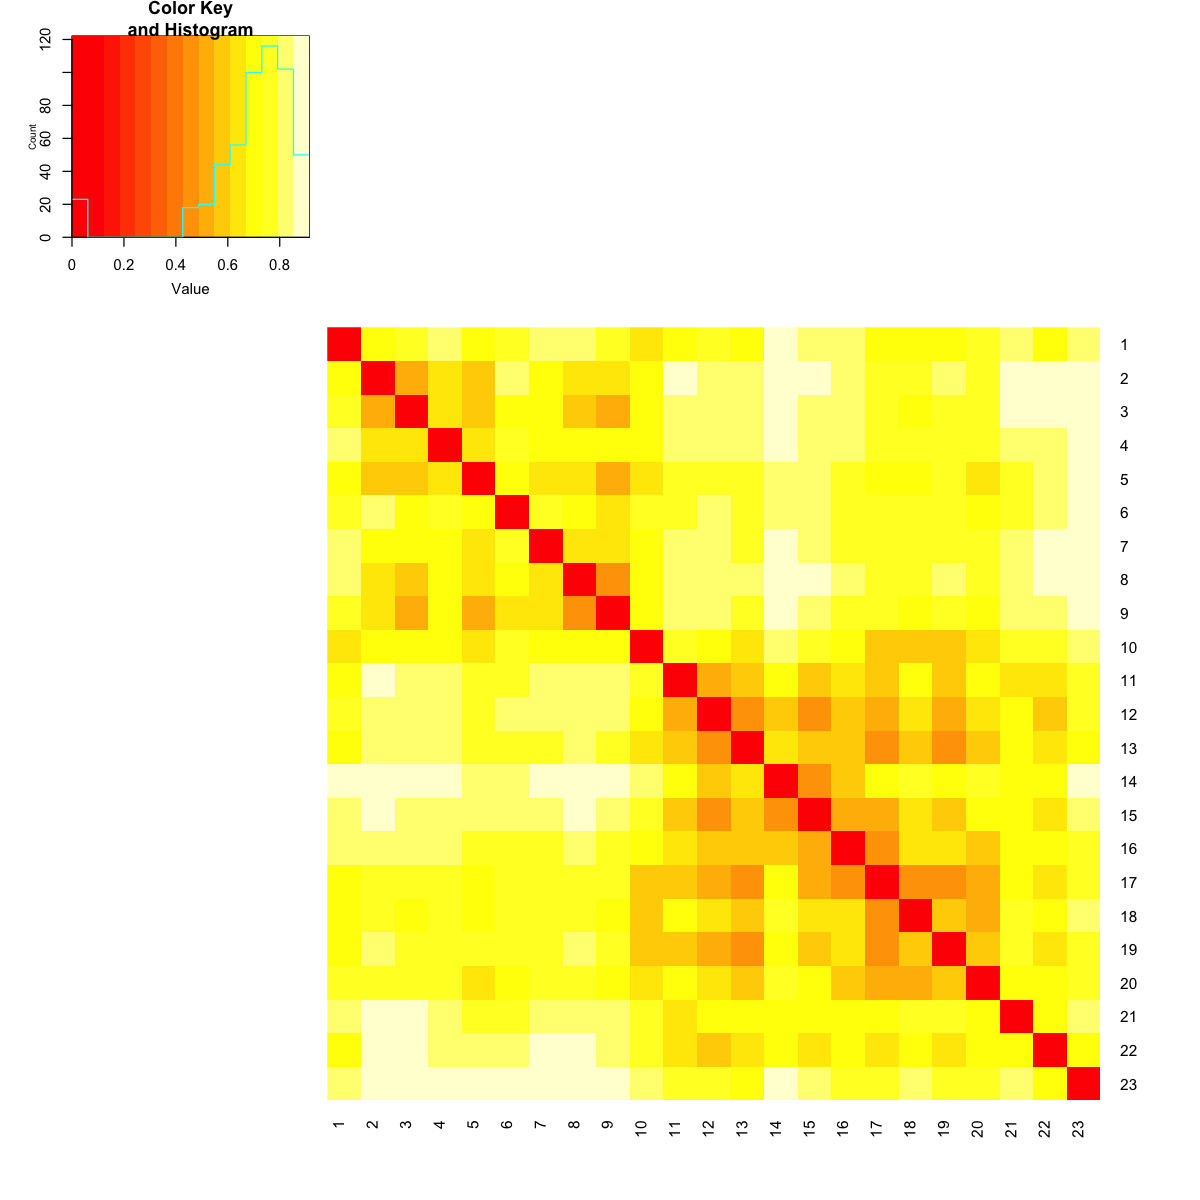

In [274]:
library("gplots")
heatmap.2(as.matrix(diatoms_brcrts),dendrogram='none', Rowv=FALSE, Colv=FALSE,trace='none')

In [300]:
#is.na(ds_wide_yearsum)

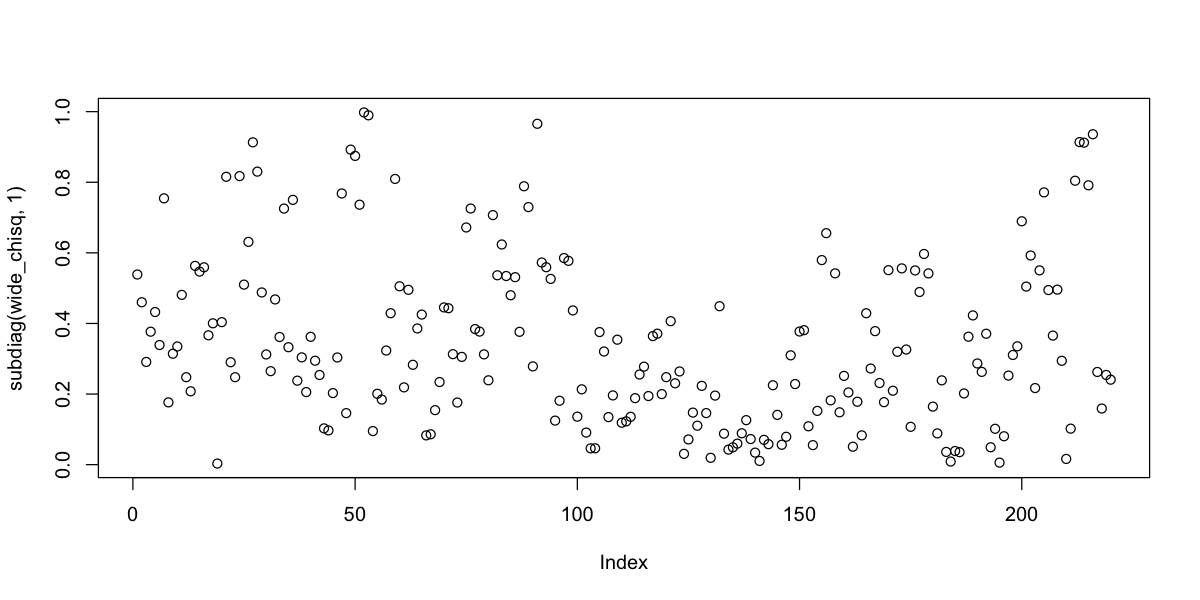

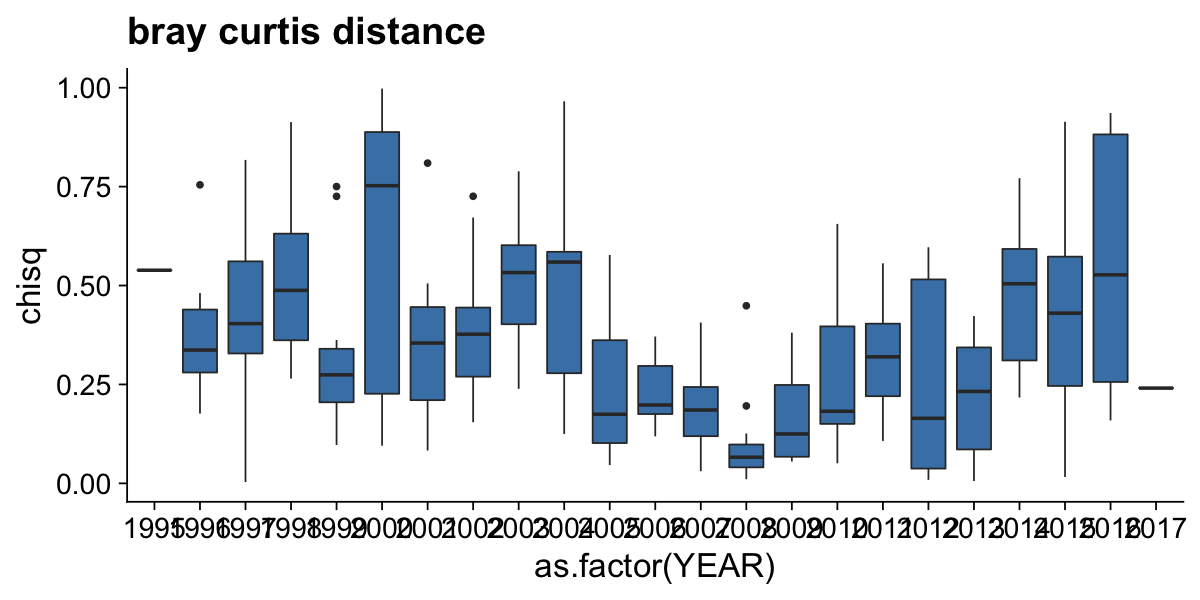

In [143]:
wide_chisq <- ds_wide %>%
    select(-date, -`palmelloid colony`) %>% #, -nanoflagellates
    #sqrt() %>%
    vegdist(method="bray")#method="jaccard")#, binary=TRUE)

options(repr.plot.width=10, repr.plot.height=5)

plot(subdiag(wide_chisq, 1))

chisq_d2d = data.frame(date = ds_wide$date[-1], chisq = subdiag(wide_chisq, 1)) %>%
    mutate(YEAR = year(date), MONTH=month(date) ,DOY=yday(date))

ggplot(data=chisq_d2d) + geom_boxplot(aes(x=as.factor(YEAR), y=chisq), fill='steelblue') + theme_cowplot(20) + 
    ggtitle("bray curtis distance") 

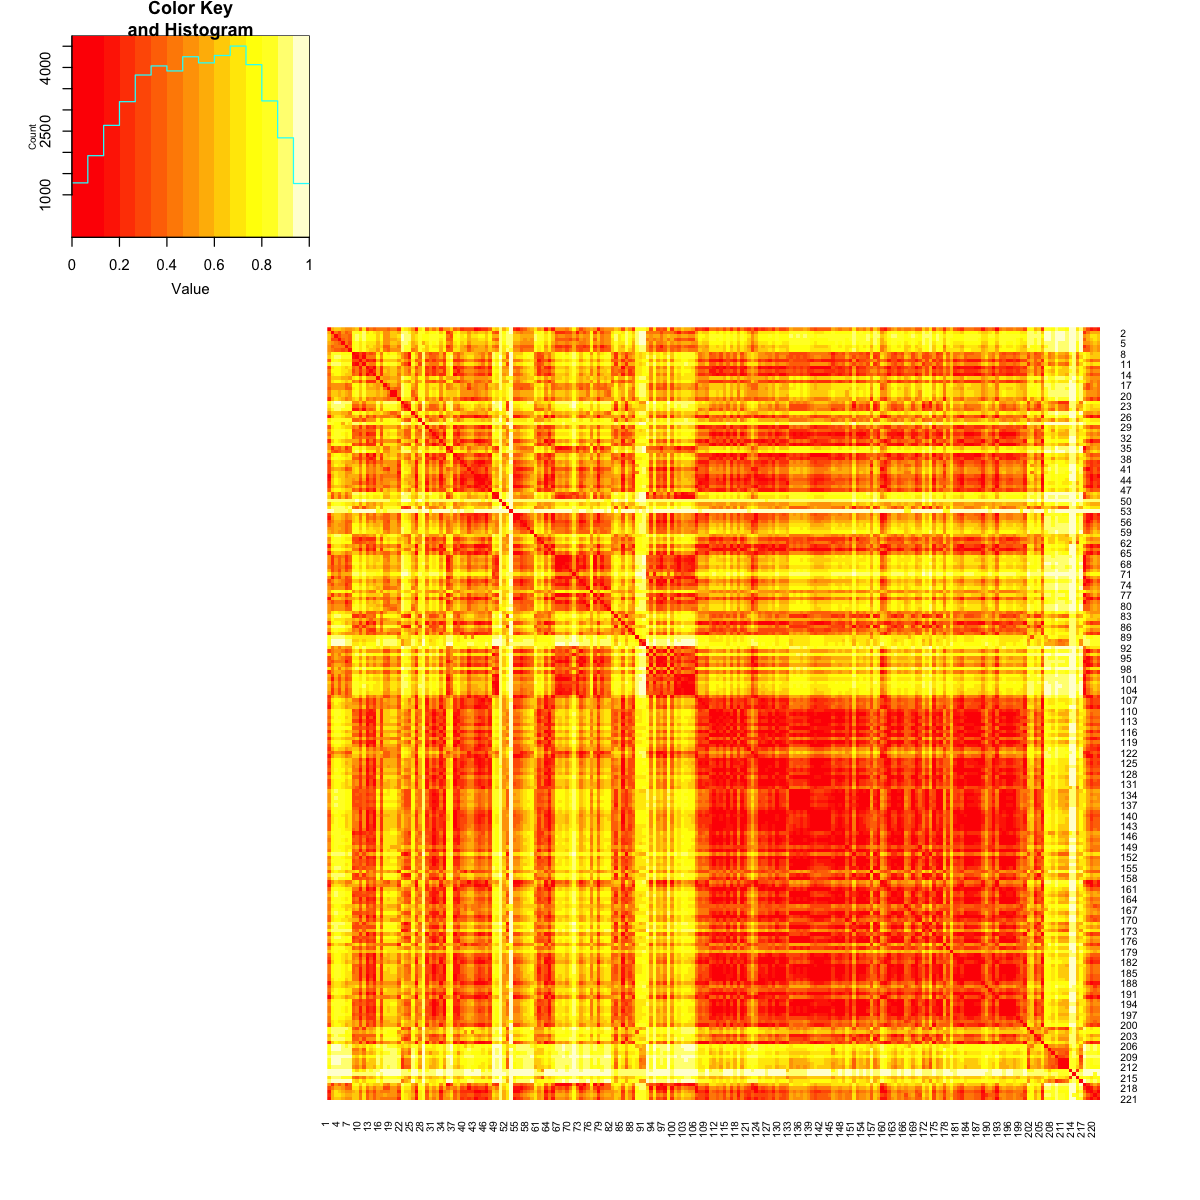

In [140]:
library("gplots")
options(repr.plot.width=10, repr.plot.height=10)
heatmap.2(as.matrix(wide_chisq),dendrogram='none', Rowv=FALSE, Colv=FALSE,trace='none')

In [278]:
??chi.square

R Information

Help files with alias or concept or title matching ‘chi.square’ using
regular expression matching:


sparklyr::ml_chisquare_test
                        Chi-square hypothesis testing for categorical
                        data.
stats::Chisquare        The (non-central) Chi-Squared Distribution
stats::chisq.test       Pearson's Chi-squared Test for Count Data
stats::mantelhaen.test
                        Cochran-Mantel-Haenszel Chi-Squared Test for
                        Count Data
stats::mcnemar.test     McNemar's Chi-squared Test for Count Data


Type '?PKG::FOO' to inspect entries 'PKG::FOO', or 'TYPE?PKG::FOO' for
entries like 'PKG::FOO-TYPE'.




In [ ]:
ds_wide_diatoms_yearsum <- ds_wide_diatoms %>%
    mutate(date = as.Date(date)) %>%
    mutate(YEAR = year(date), DOY=yday(date)) %>%
    group_by(YEAR) %>% 
    select(-date) %>%
    summarize_all(sum) 

shannon_div_diatoms_year <- ds_wide_diatoms_yearsum %>%
    select(-YEAR, -DOY) %>%
    diversity()

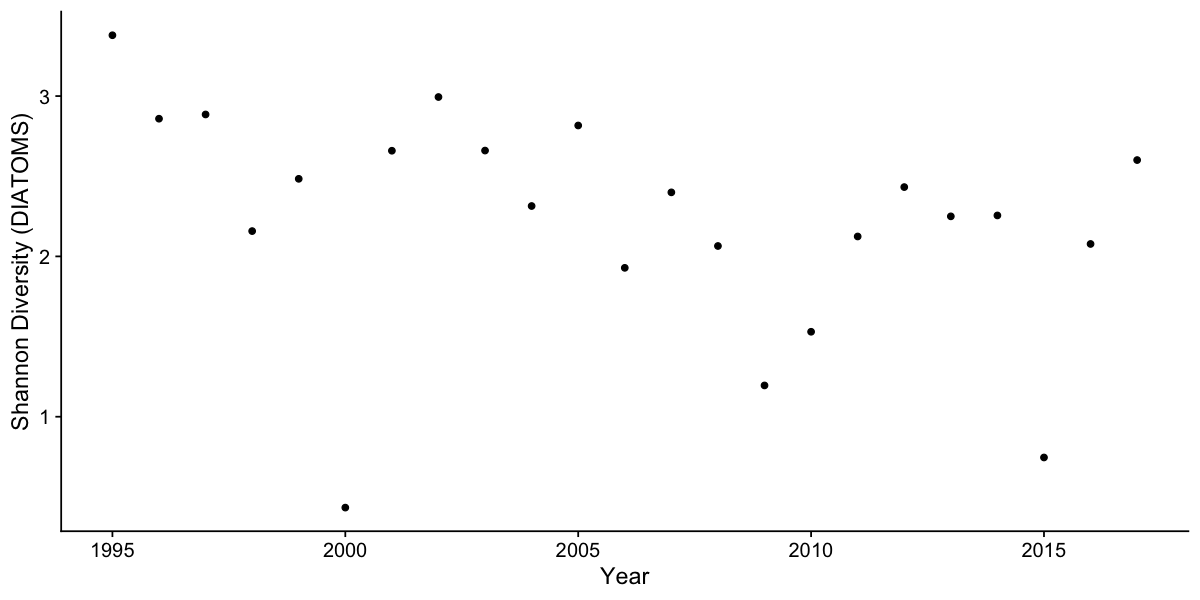

In [396]:
year = ds_wide_yearsum$YEAR


options(repr.plot.width=10, repr.plot.height=5)

ggplot() + geom_point(aes(x = year, y = shannon_div_diatoms_year)) + theme_cowplot() + ylab("Shannon Diversity (DIATOMS)") + xlab("Year")
      #scale_x_date(date_breaks = "years" , date_labels = "%y")


ggsave("YEARsum_ShannonTimeSeries_DIATOMS.png", width=10, height=5)

# BRAY CURTIS

[1] 0.4978452 0.6277192 0.5767488 0.5604833 0.5642636 0.5432470

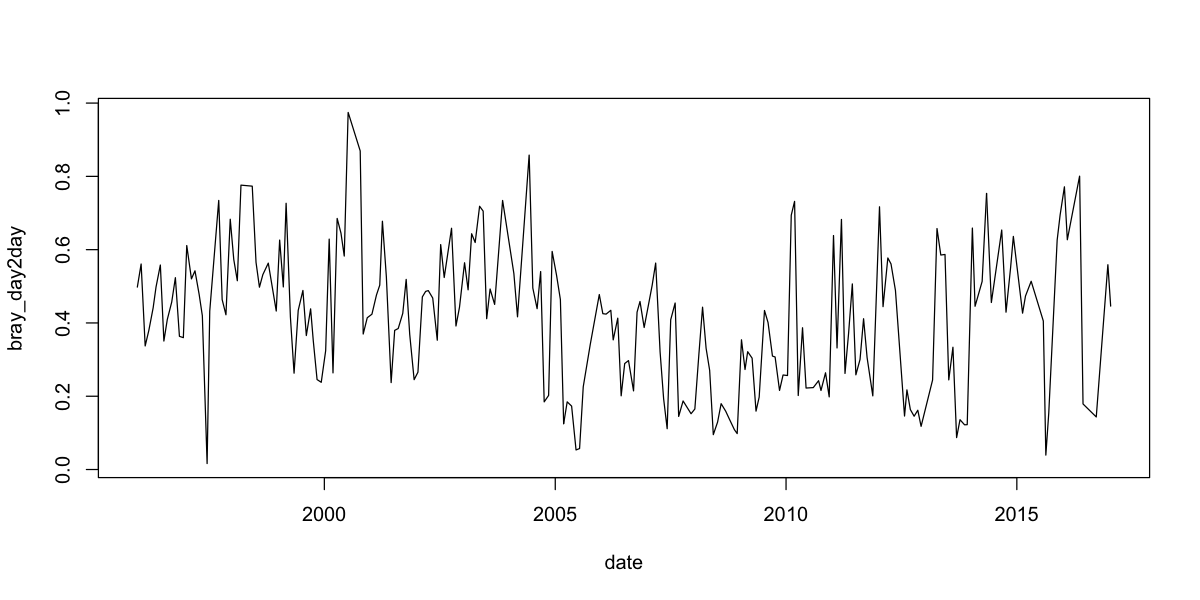

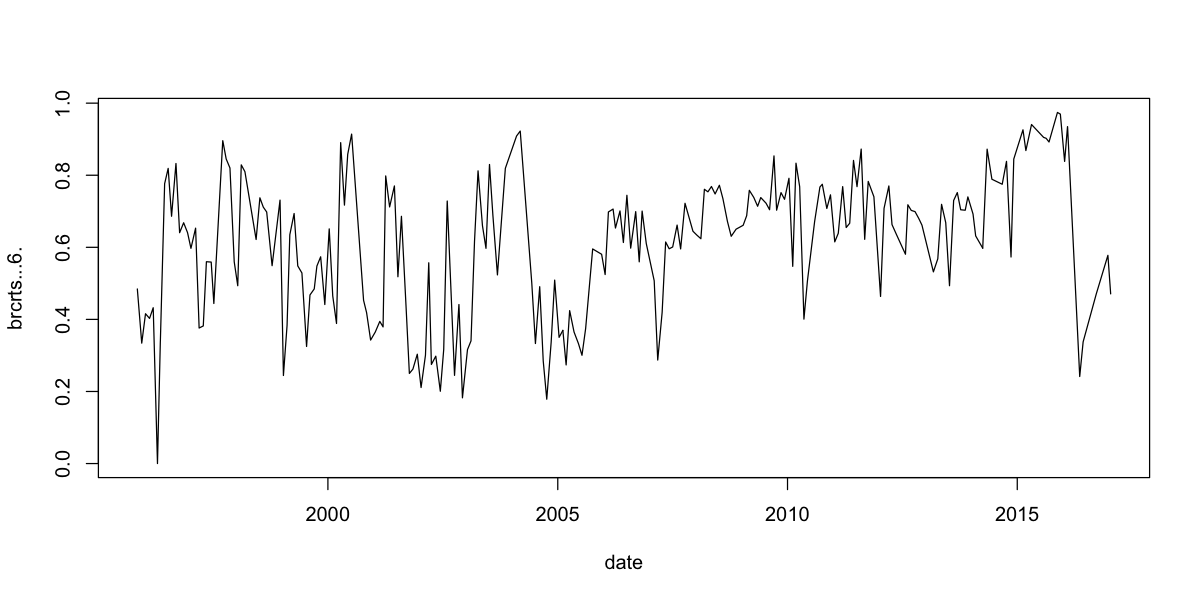

In [386]:
bray_curtis <- ds_wide %>%
    select(-date, -`palmelloid colony`) %>%
    sqrt() %>%
    vegdist(method="bray")#, binary=TRUE)

head(bray_curtis)

subdiag <- function (dist_obj, d) {
  if (!inherits(dist_obj, "dist")) stop("please provide a 'dist' object!")
  n <- attr(dist_obj, "Size")
  if (d < 1 || d > (n - 1)) stop(sprintf("'d' needs be between 1 and %d", n - 1L))
  j_1 <- c(0, seq.int(from = n - 1, by = -1, length = n - d - 1))
  subdiag_ind <- d + cumsum(j_1)
  dist_obj[subdiag_ind]
  }

br_curt_d2d = data.frame(date = ds_wide$date[-1], bray_day2day = subdiag(bray_curtis, 1))


br_curt_d1 = data.frame(date = ds_wide$date, brcrts[,6])

plot(br_curt_d2d, type='l')

plot(br_curt_d1, type='l')

In [387]:
heatmap(bray_curtis)

ERROR: Error in heatmap(bray_curtis): 'x' must be a numeric matrix


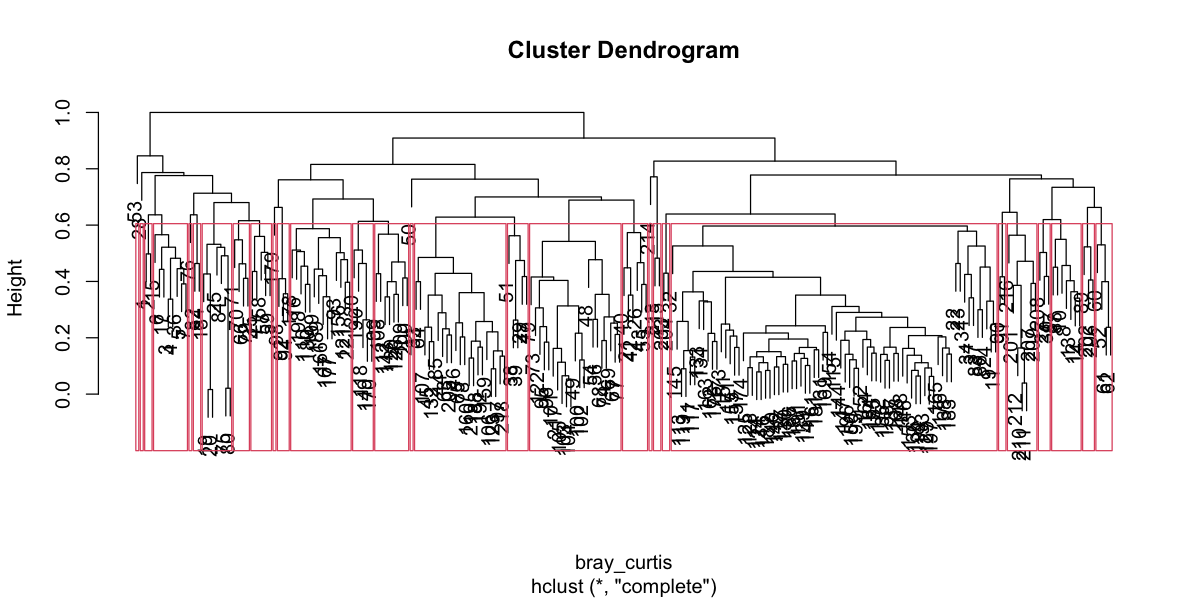

In [388]:
clus <- hclust(bray_curtis)
plot(clus)
rect.hclust(clus, h = 0.6)

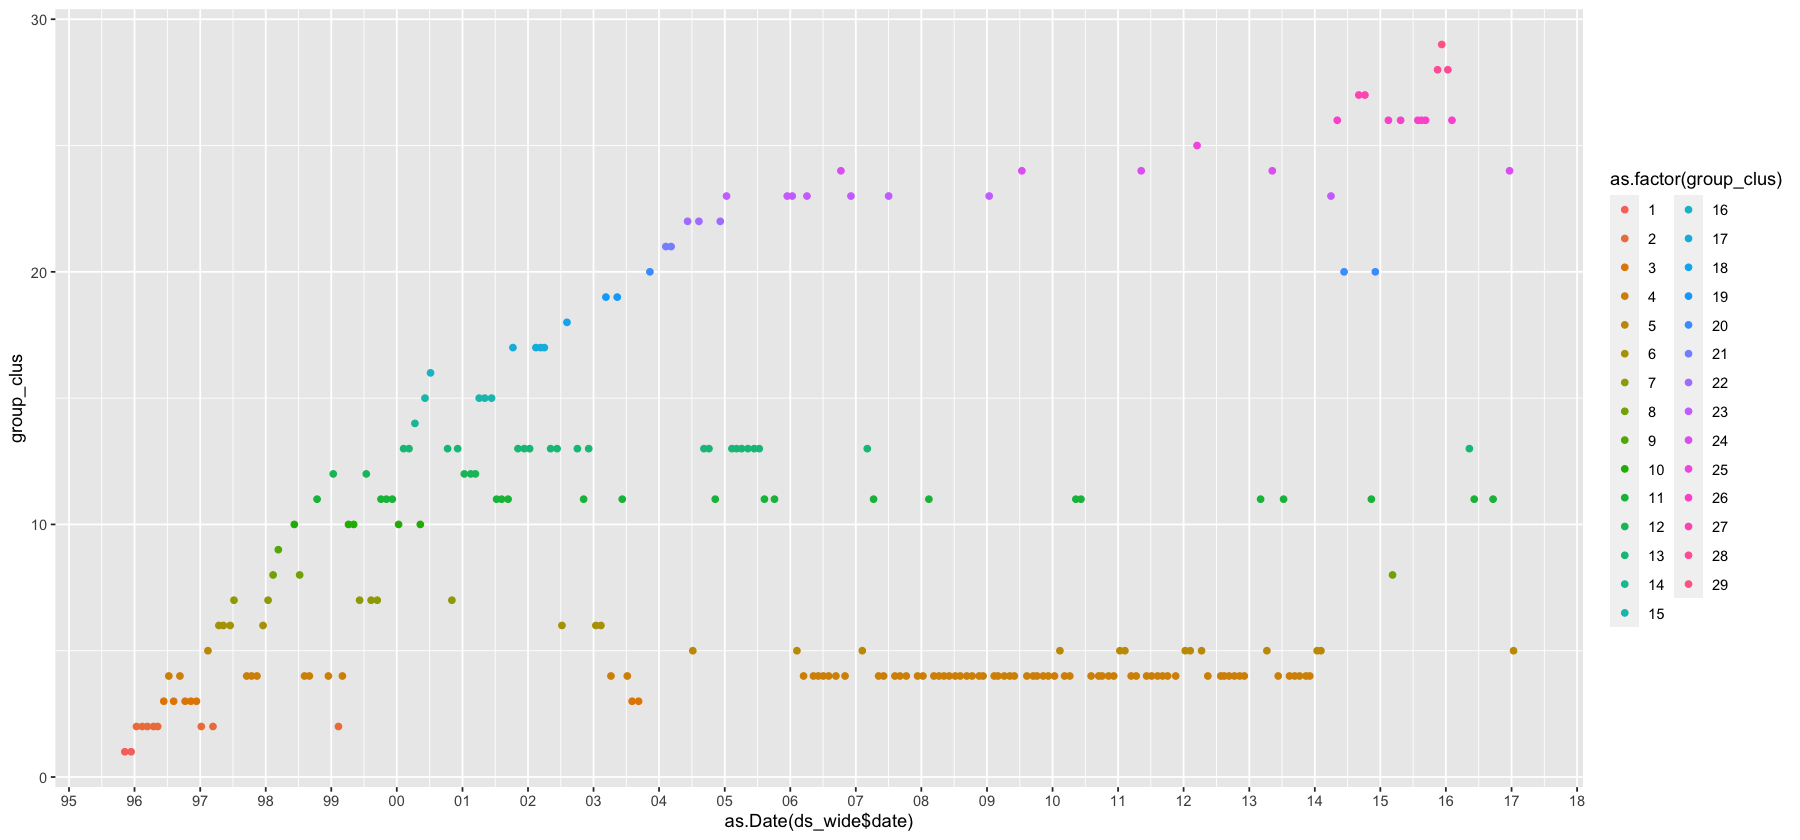

In [330]:
# extract groups with similarity > 0.6 between
group_clus <- cutree(clus, h=0.6)

ggplot() + geom_point(aes(x = as.Date(ds_wide$date), y = group_clus, col=as.factor(group_clus)))+
      scale_x_date(date_breaks = "years" , date_labels = "%y")


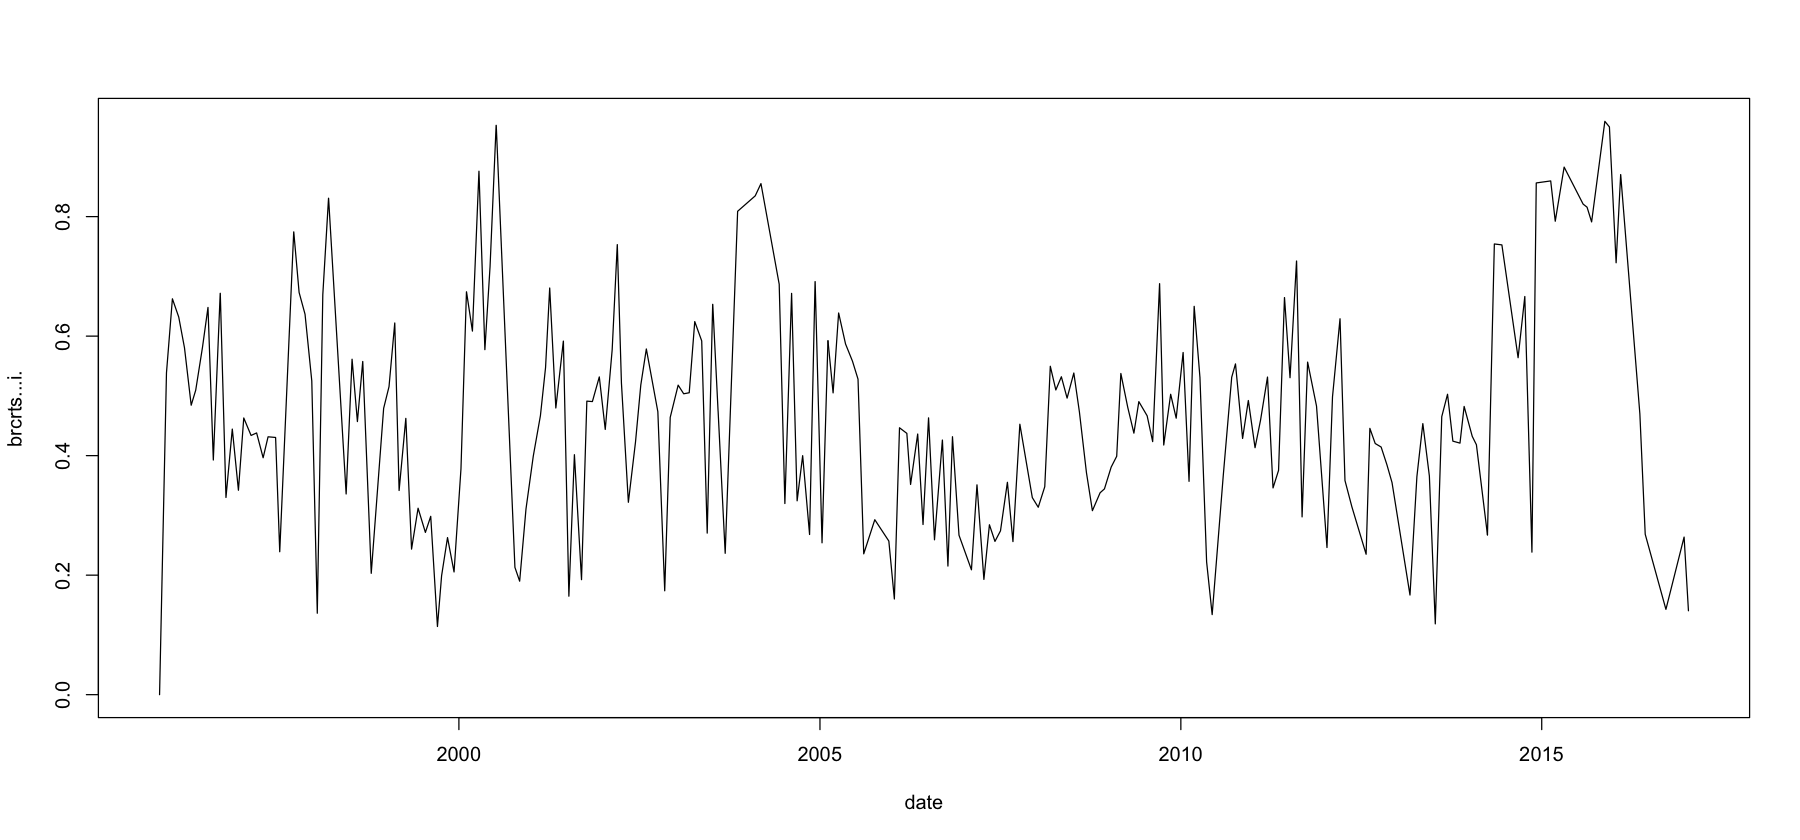

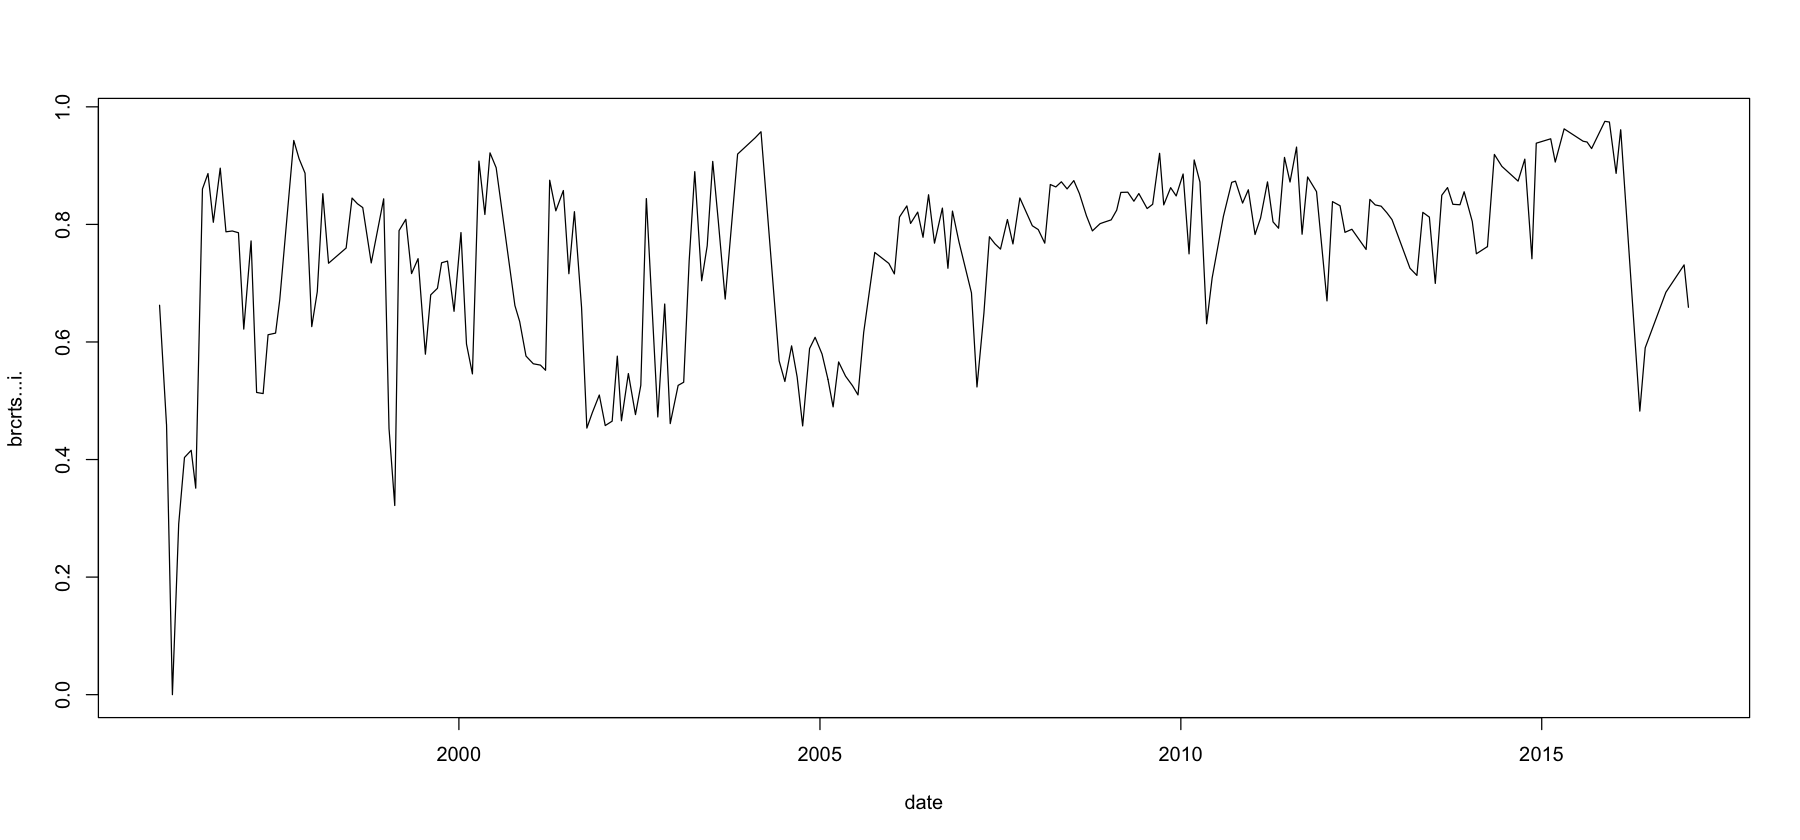

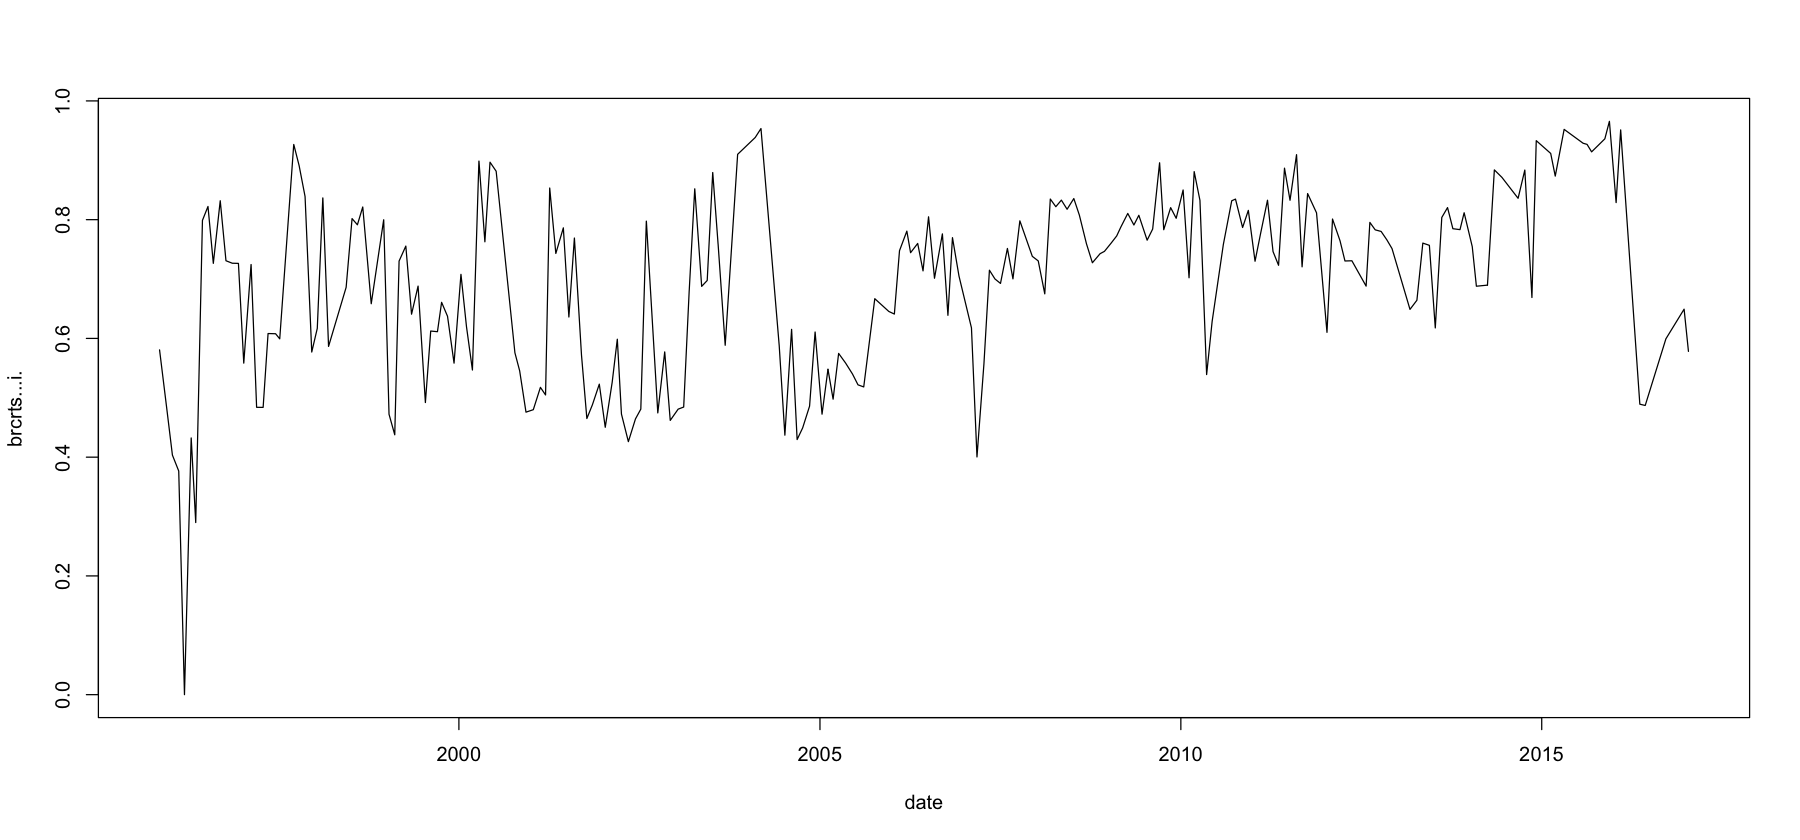

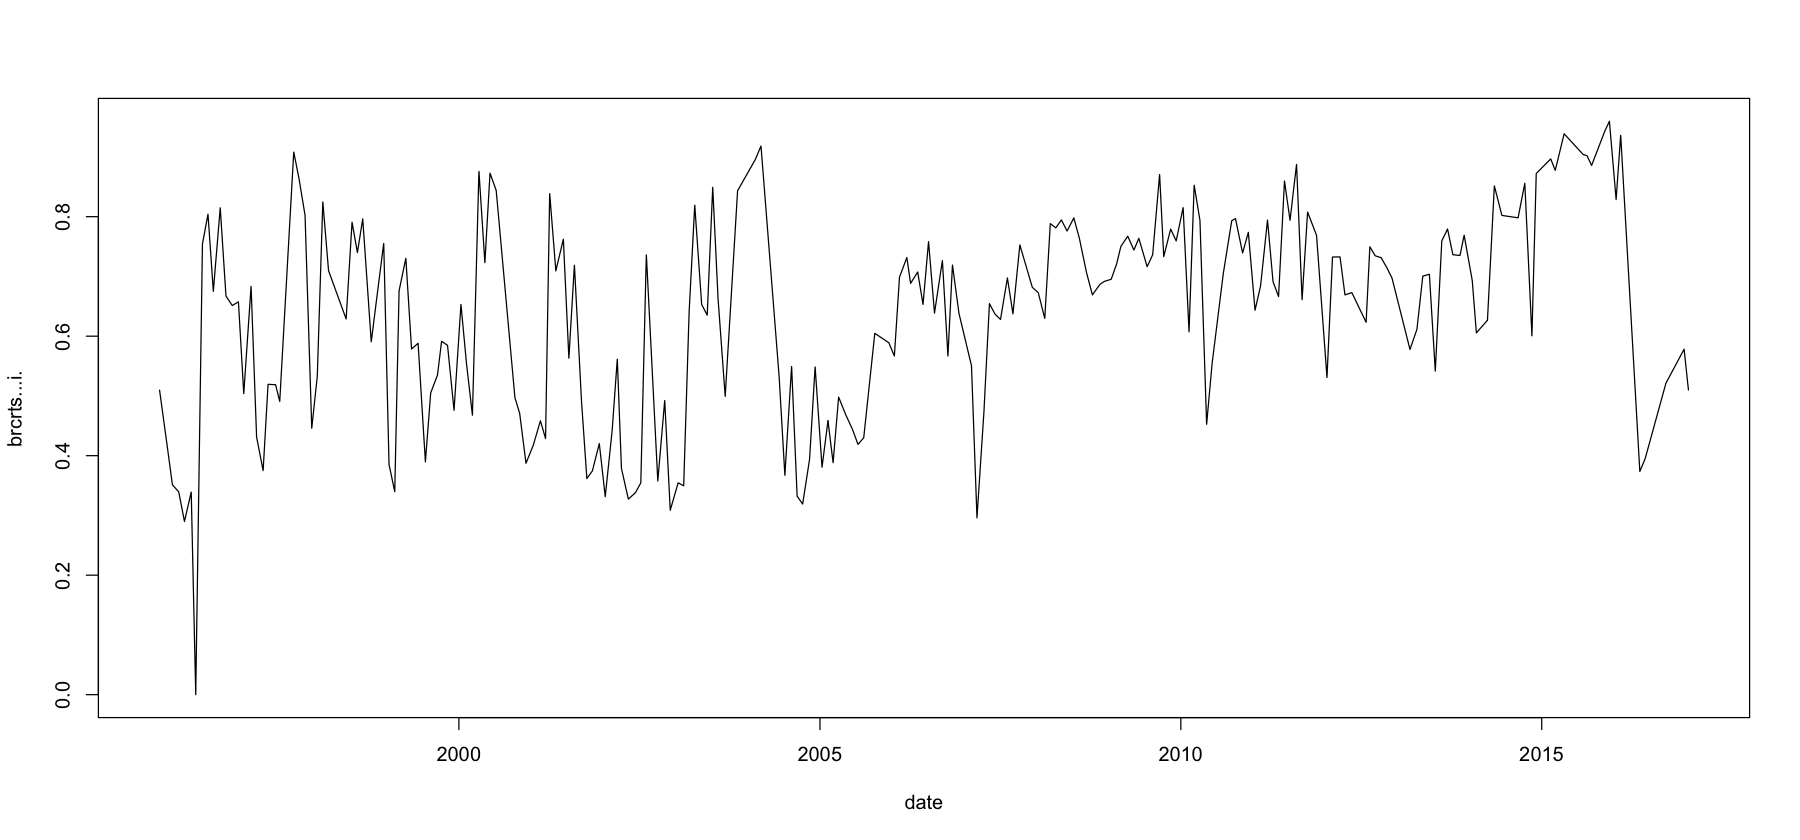

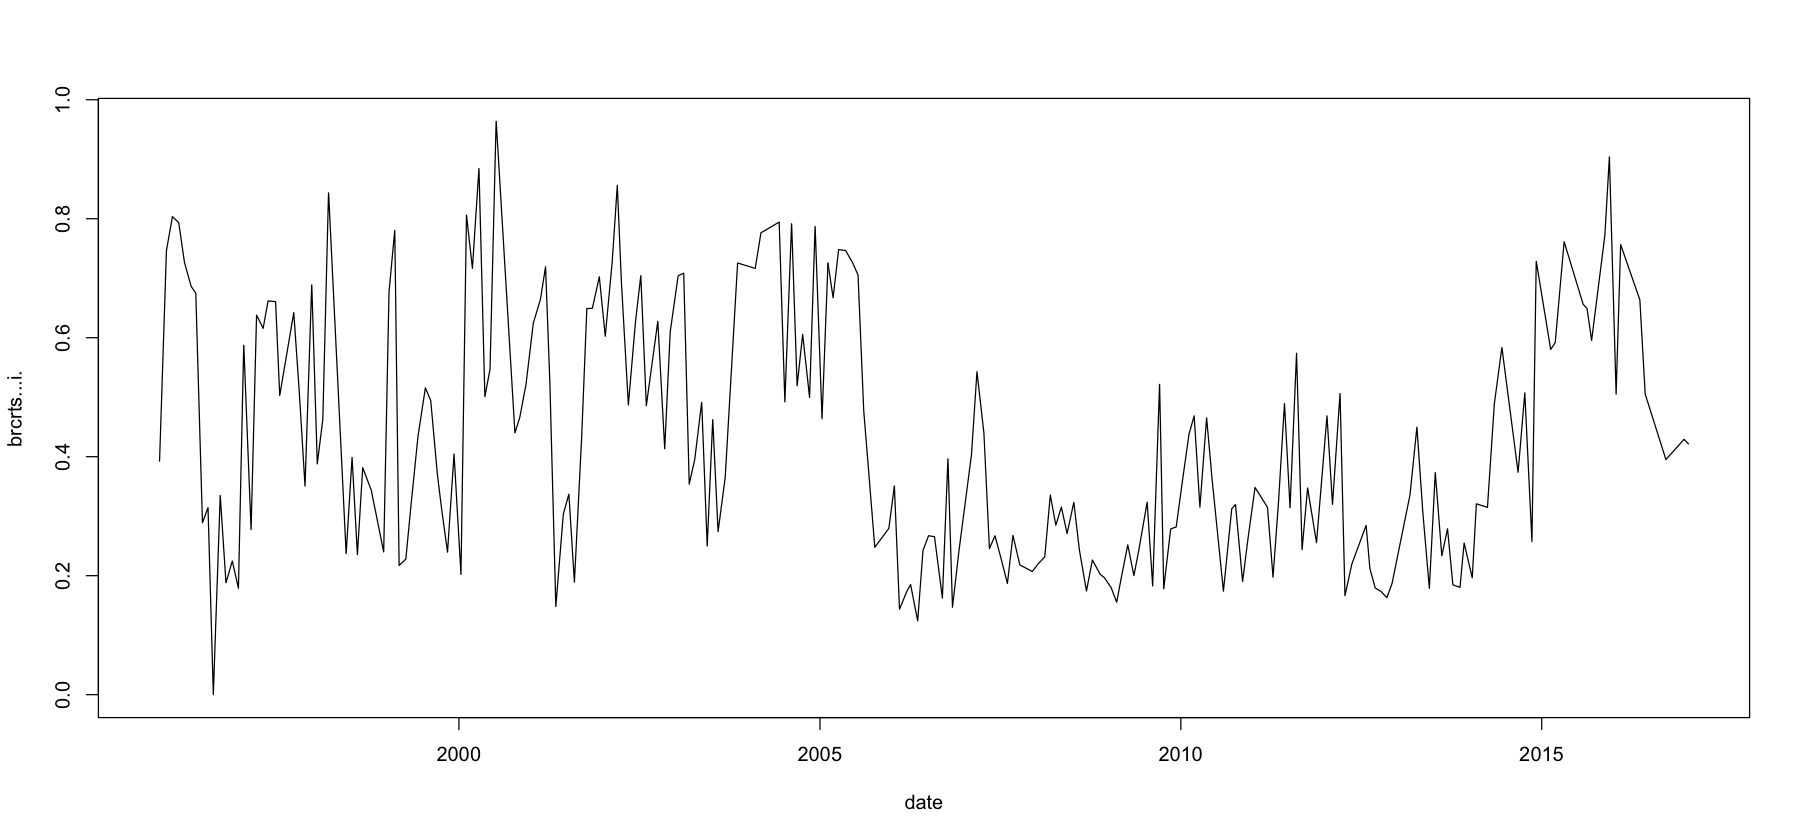

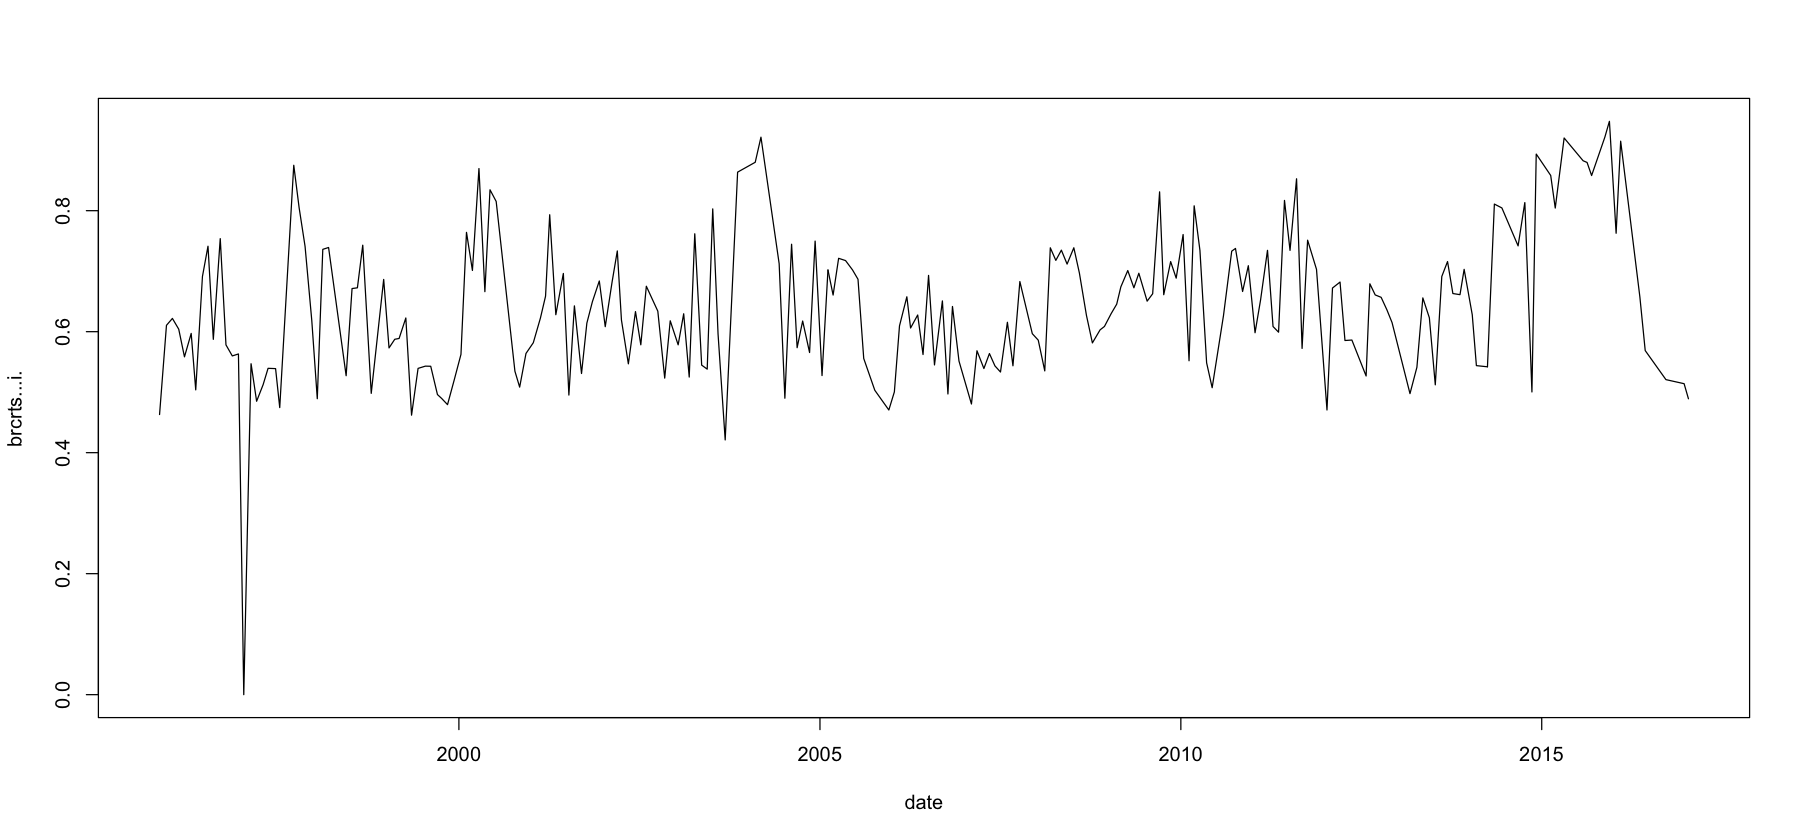

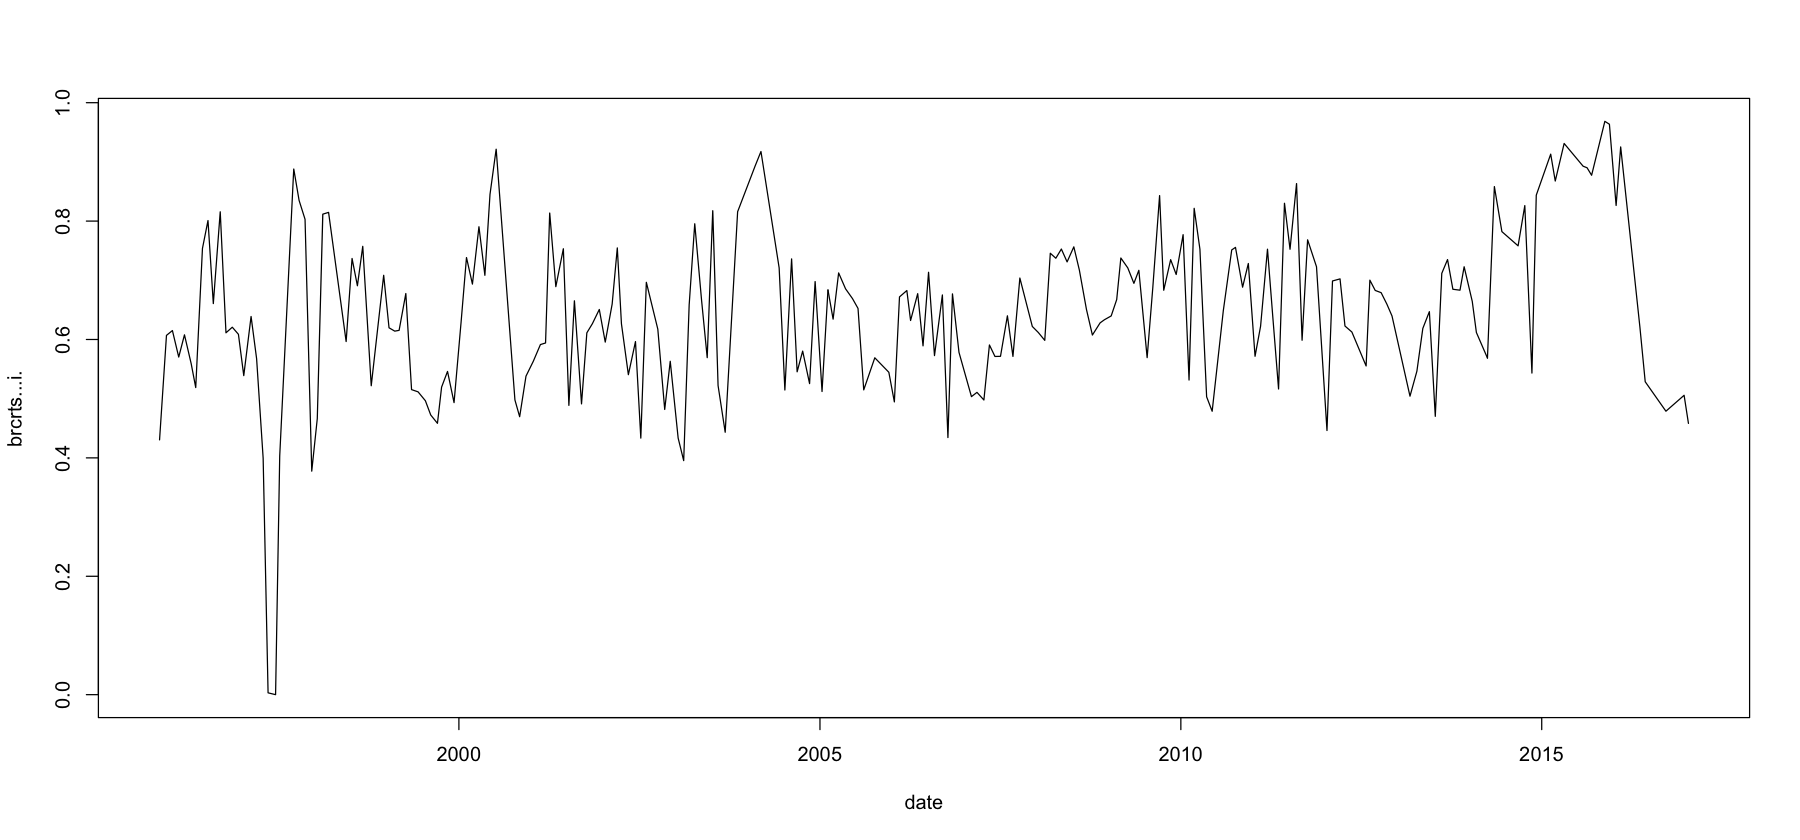

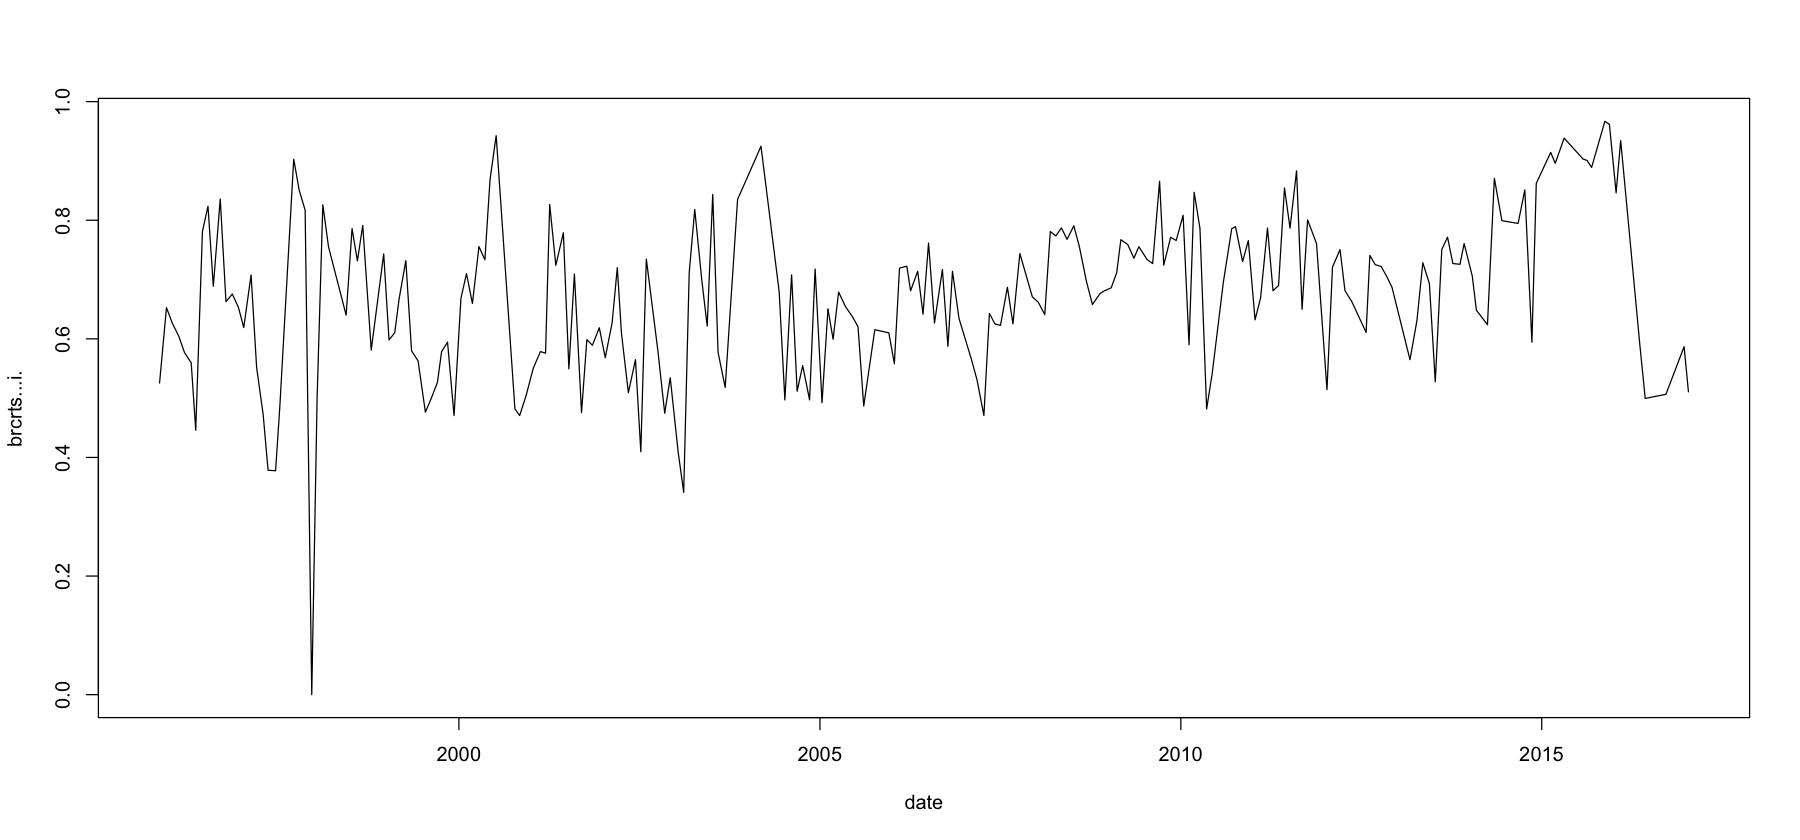

In [312]:
for (i in c(1,3,5,7,10,15,20,25)) {
    plot(data.frame(date = ds_wide$date, brcrts[,i]), type='l')}

In [263]:
brcrts = as.data.frame(as.matrix(bray_curtis))
brcrts[,1]

[1] 0.0000000 0.5386657 0.6624731 0.6319423 0.5806437 0.4843812 0.5096433
  [8] 0.5808876 0.6480127 0.3926875 0.6717004 0.3299969 0.4444453 0.3420888
 [15] 0.4630557 0.4338086 0.4379996 0.3964525 0.4315309 0.4304355 0.2391801
 [22] 0.7744544 0.6731153 0.6366509 0.5255470 0.1363100 0.6699645 0.8307967
 [29] 0.3358640 0.5613391 0.4570137 0.5575711 0.2030853 0.4794659 0.5155304
 [36] 0.6220004 0.3416805 0.4623627 0.2435531 0.3120390 0.2715144 0.2984487
 [43] 0.1140674 0.1990365 0.2628846 0.2053369 0.3775986 0.6741969 0.6084274
 [50] 0.8759597 0.5773655 0.7150650 0.9527905 0.2130315 0.1899055 0.3107569
 [57] 0.3994229 0.4668819 0.5474535 0.6805206 0.4797419 0.5916899 0.1648193
 [64] 0.4015729 0.1924469 0.4912162 0.4904871 0.5317457 0.4438557 0.5767796
 [71] 0.7531268 0.5207070 0.3219400 0.4223191 0.5184052 0.5785215 0.4740142
 [78] 0.1738268 0.4641451 0.5179819 0.5035106 0.5052437 0.6243344 0.5921947
 [85] 0.2703811 0.6532345 0.4746751 0.2365845 0.8089346 0.8347541 0.8552617
 [92] 0.6873923 0.3198794 0.6715372 0.3244057 0.3999690 0.2680406 0.6912584
 [99] 0.2541315 0.5921218 0.5050052 0.6387280 0.5868342 0.5581195 0.5280832
[106] 0.2356717 0.2927790 0.2570602 0.1601254 0.4466339 0.4372742 0.3517622
[113] 0.4361902 0.2847464 0.4632159 0.2591653 0.4260899 0.2152250 0.4316567
[120] 0.2668707 0.2089504 0.3511031 0.1928654 0.2843463 0.2565087 0.2741611
[127] 0.3553980 0.2561511 0.4525806 0.3297824 0.3136452 0.3480364 0.5495795
[134] 0.5099057 0.5320062 0.4962744 0.5382766 0.4738262 0.3713353 0.3078843
[141] 0.3378716 0.3443612 0.3808376 0.3989275 0.5374971 0.4806517 0.4376496
[148] 0.4903926 0.4666944 0.4234661 0.6877799 0.4177802 0.5027010 0.4626767
[155] 0.5726104 0.3570105 0.6498322 0.5316046 0.2219044 0.1339690 0.3699369
[162] 0.5313078 0.5535255 0.4287520 0.4922684 0.4132969 0.4596993 0.5315241
[169] 0.3459761 0.3753677 0.6645206 0.5304060 0.7257174 0.2975193 0.5565521
[176] 0.4830259 0.2462375 0.4986664 0.6290258 0.3583732 0.3143415 0.2349861
[183] 0.4456647 0.4202980 0.4144019 0.3850165 0.3550827 0.1667047 0.3650276
[190] 0.4535948 0.3660515 0.1184934 0.4655653 0.5027400 0.4242594 0.4209511
[197] 0.4823318 0.4323035 0.4183217 0.2673881 0.7542370 0.7526766 0.5638424
[204] 0.6663026 0.2385268 0.8563654 0.8597342 0.7922704 0.8828774 0.8209416
[211] 0.8157926 0.7911161 0.9594526 0.9501371 0.7227617 0.8703354 0.4705412
[218] 0.2684548 0.1427431 0.2637324 0.1404194

# Now let's plot some raw counts:

In [106]:
options(repr.plot.width=15, repr.plot.height=7)

Warning message:
“Removed 1 rows containing missing values (geom_point).”
Warning message:
“Removed 2 rows containing missing values (geom_point).”


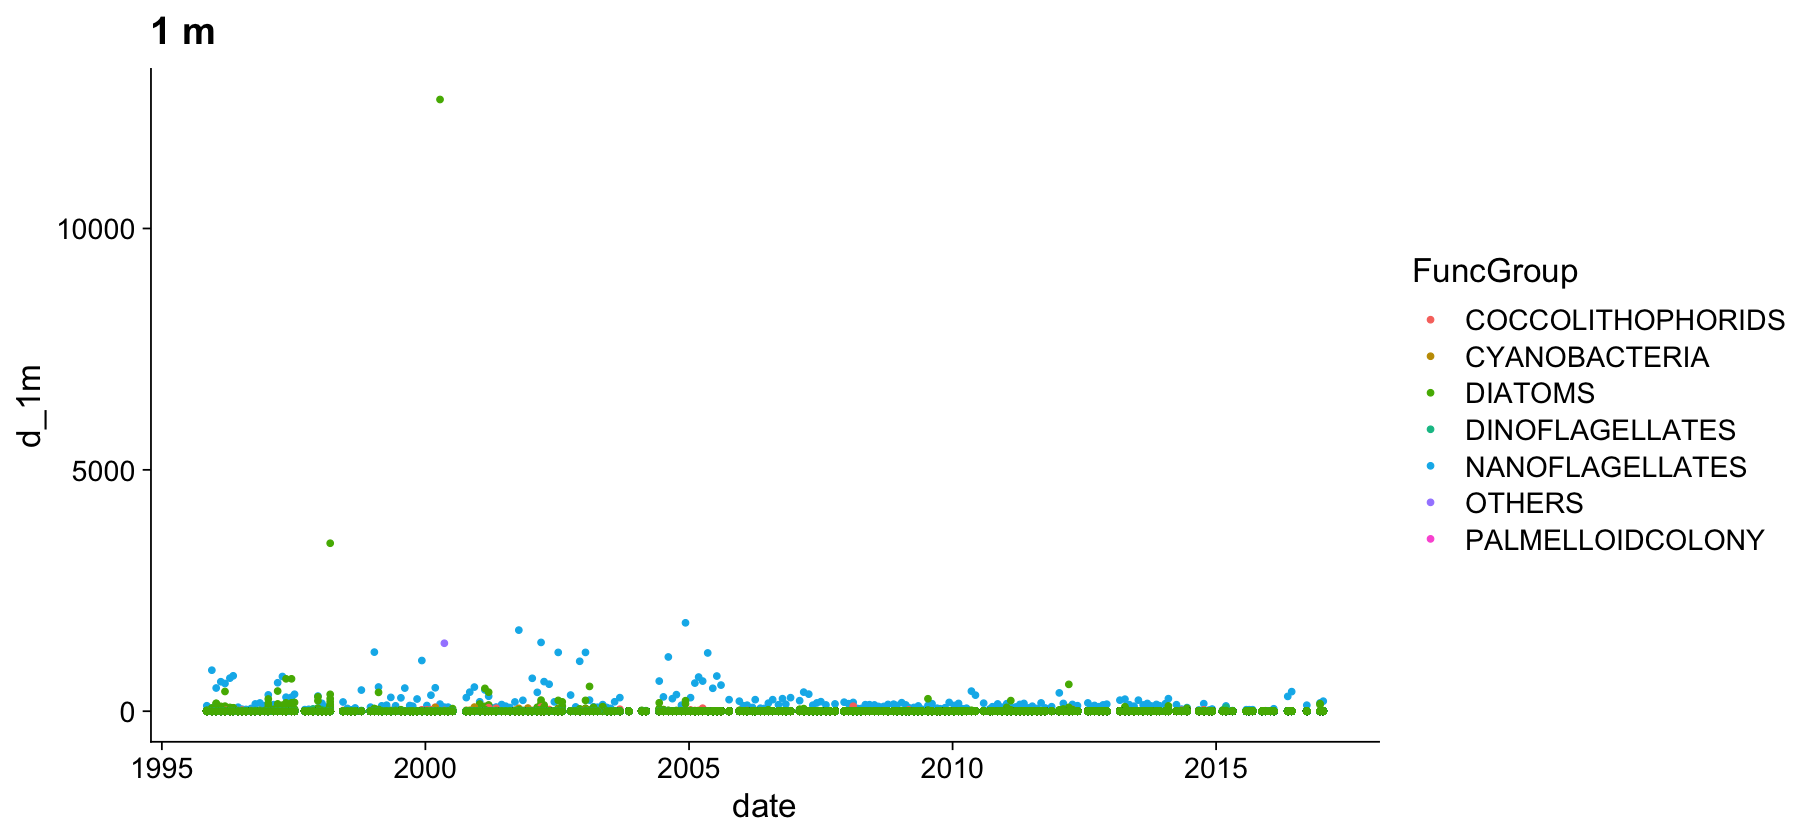

Warning message:
“Removed 1 rows containing missing values (geom_point).”


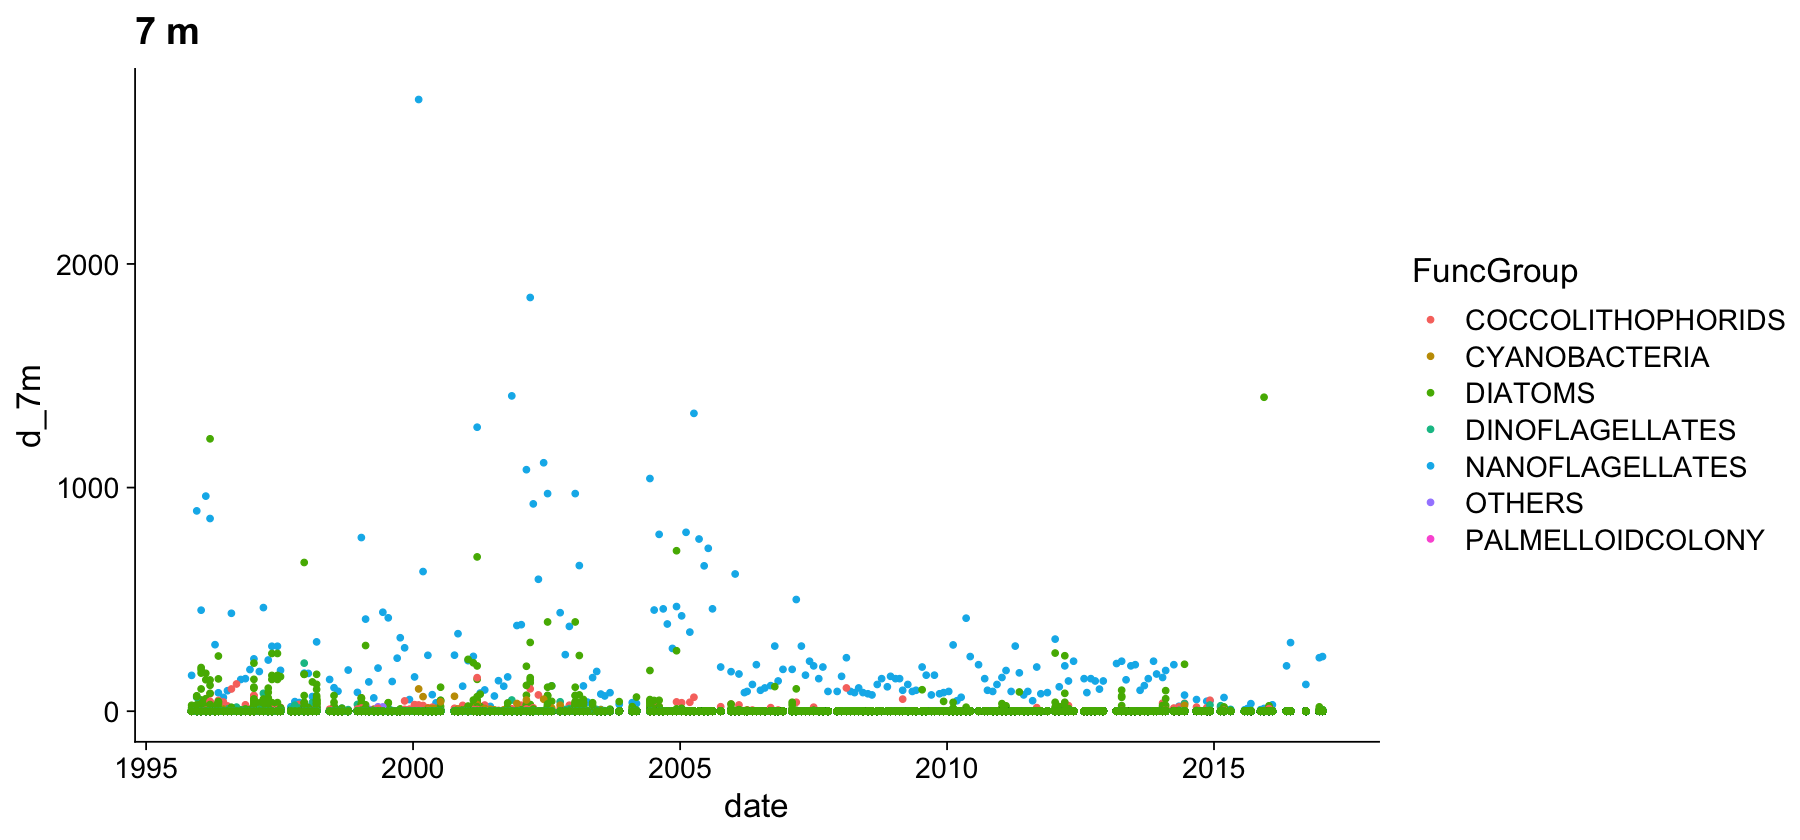

Warning message:
“Removed 1 rows containing missing values (geom_point).”


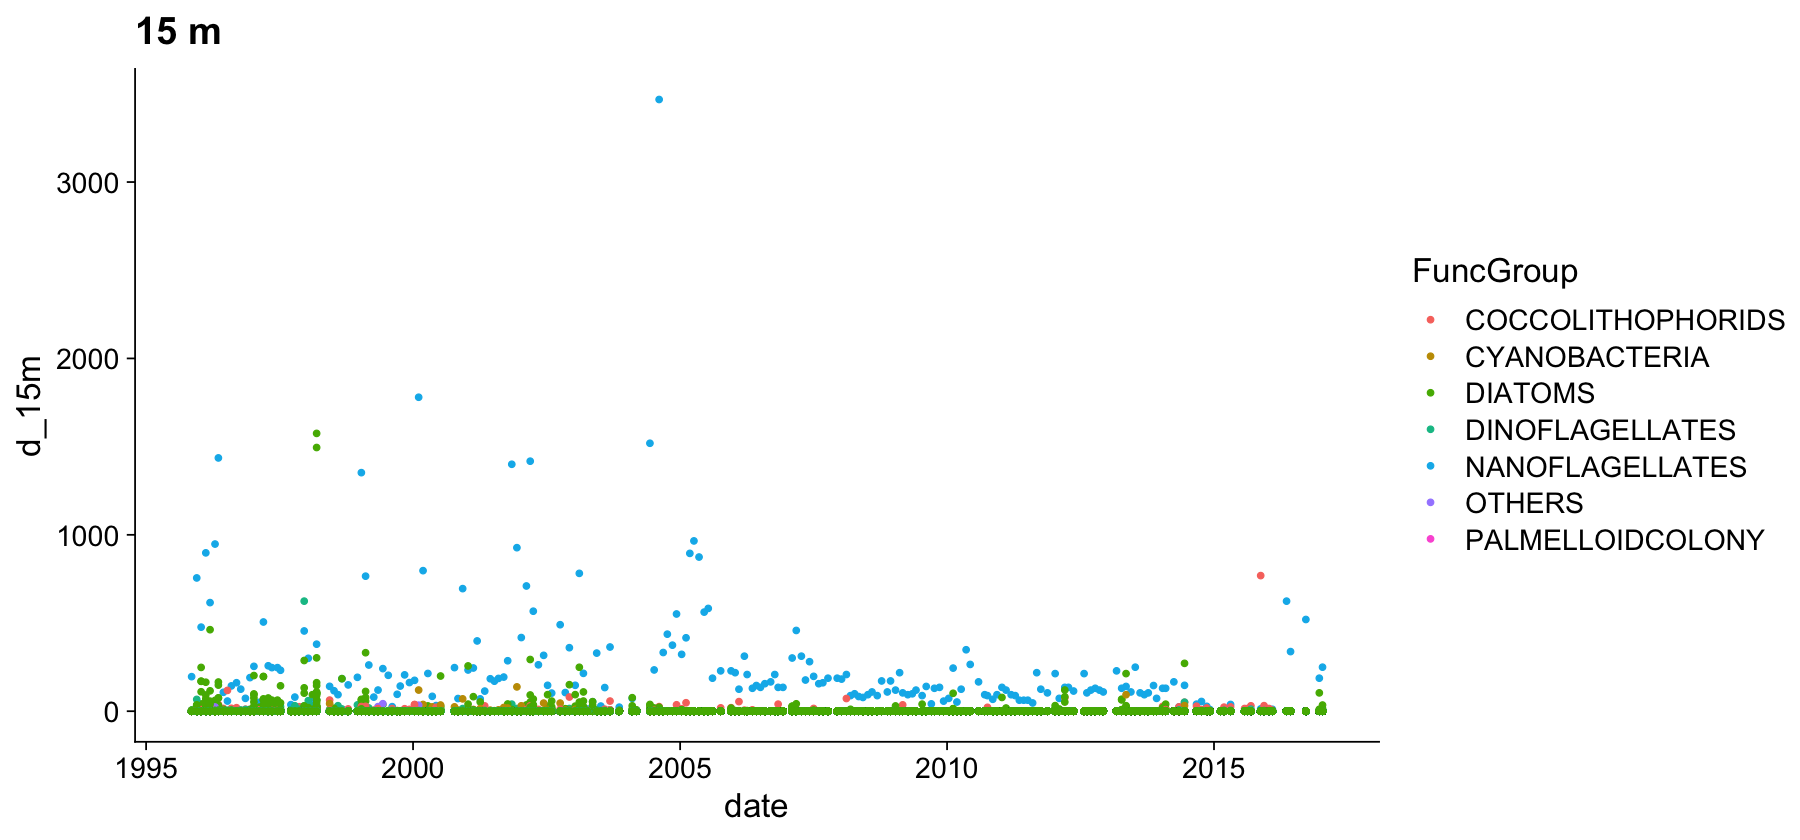

Warning message:
“Removed 1 rows containing missing values (geom_point).”


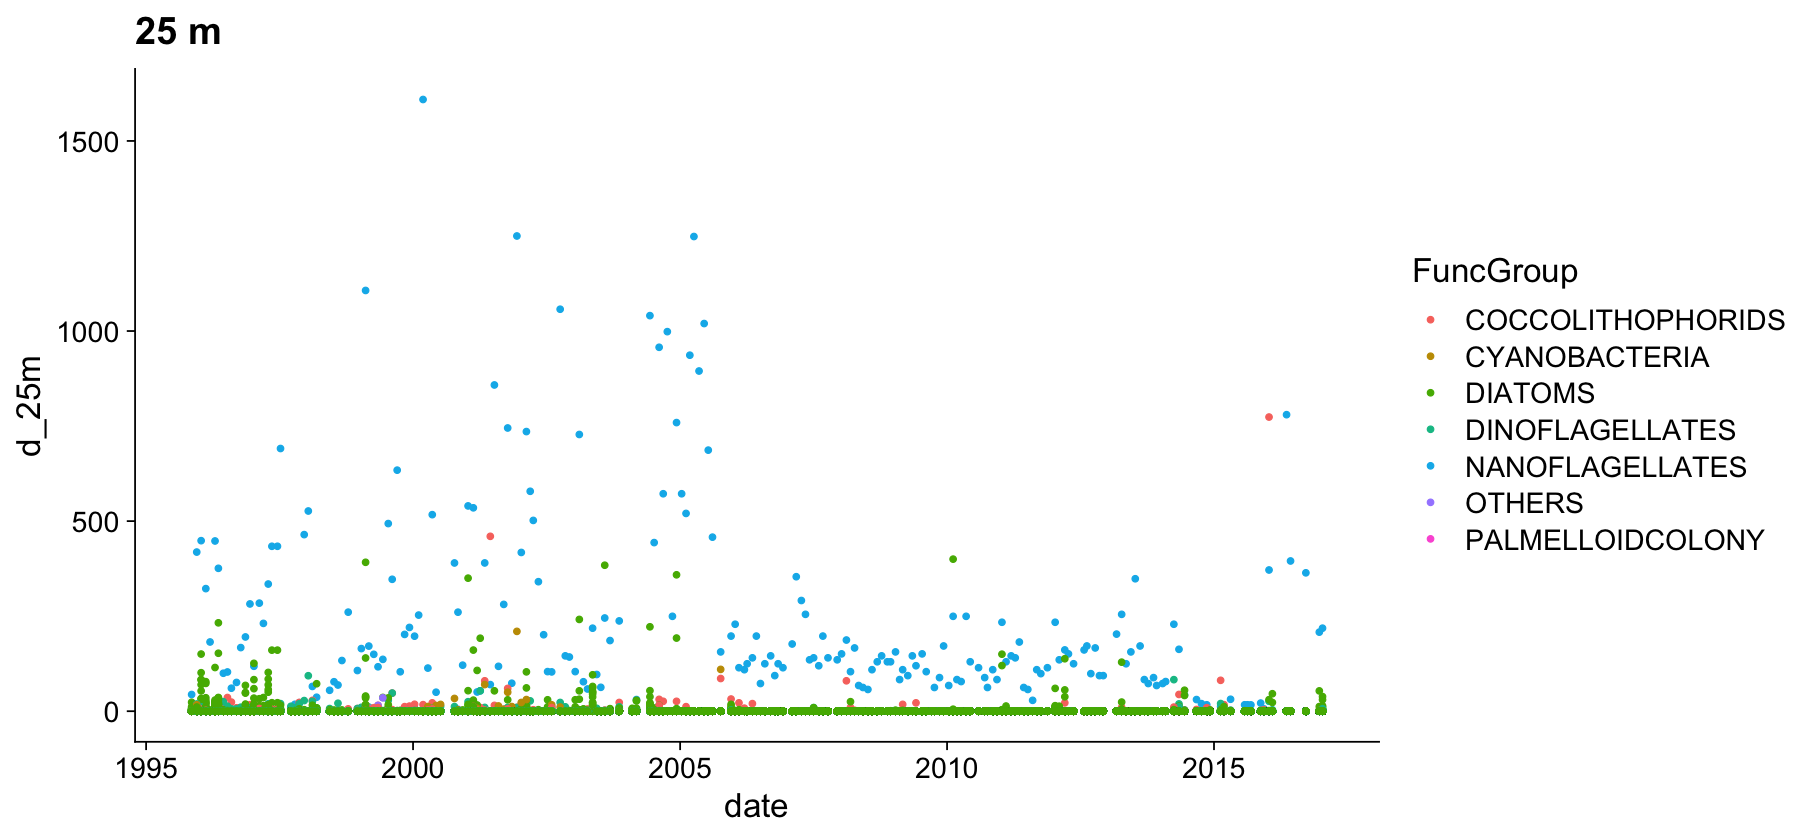

Warning message:
“Removed 1 rows containing missing values (geom_point).”


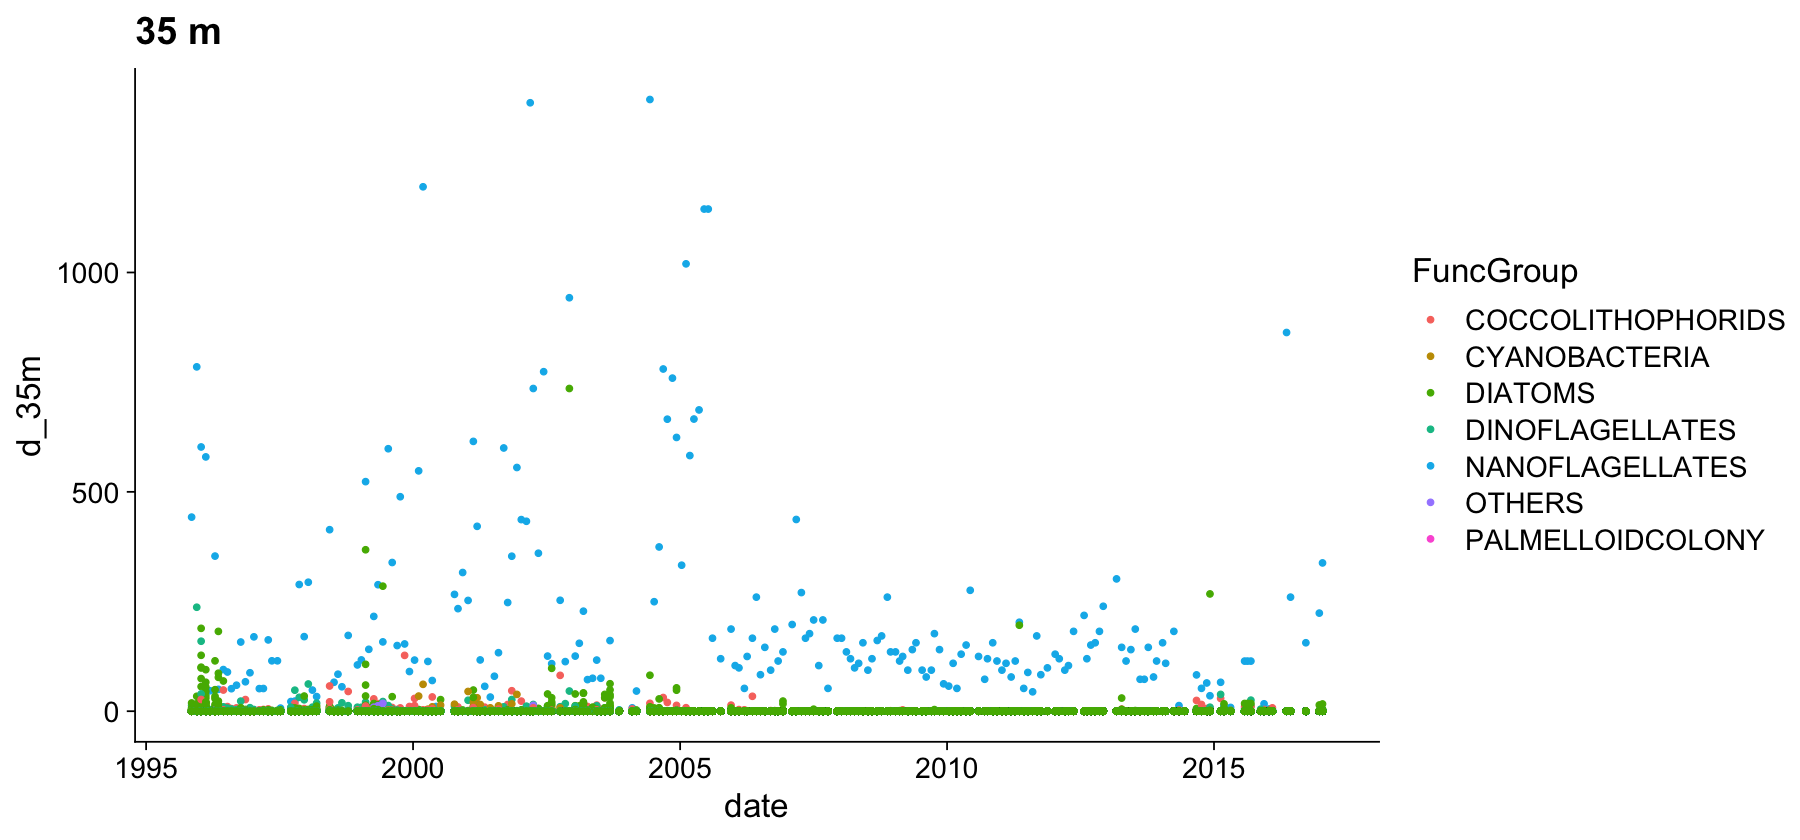

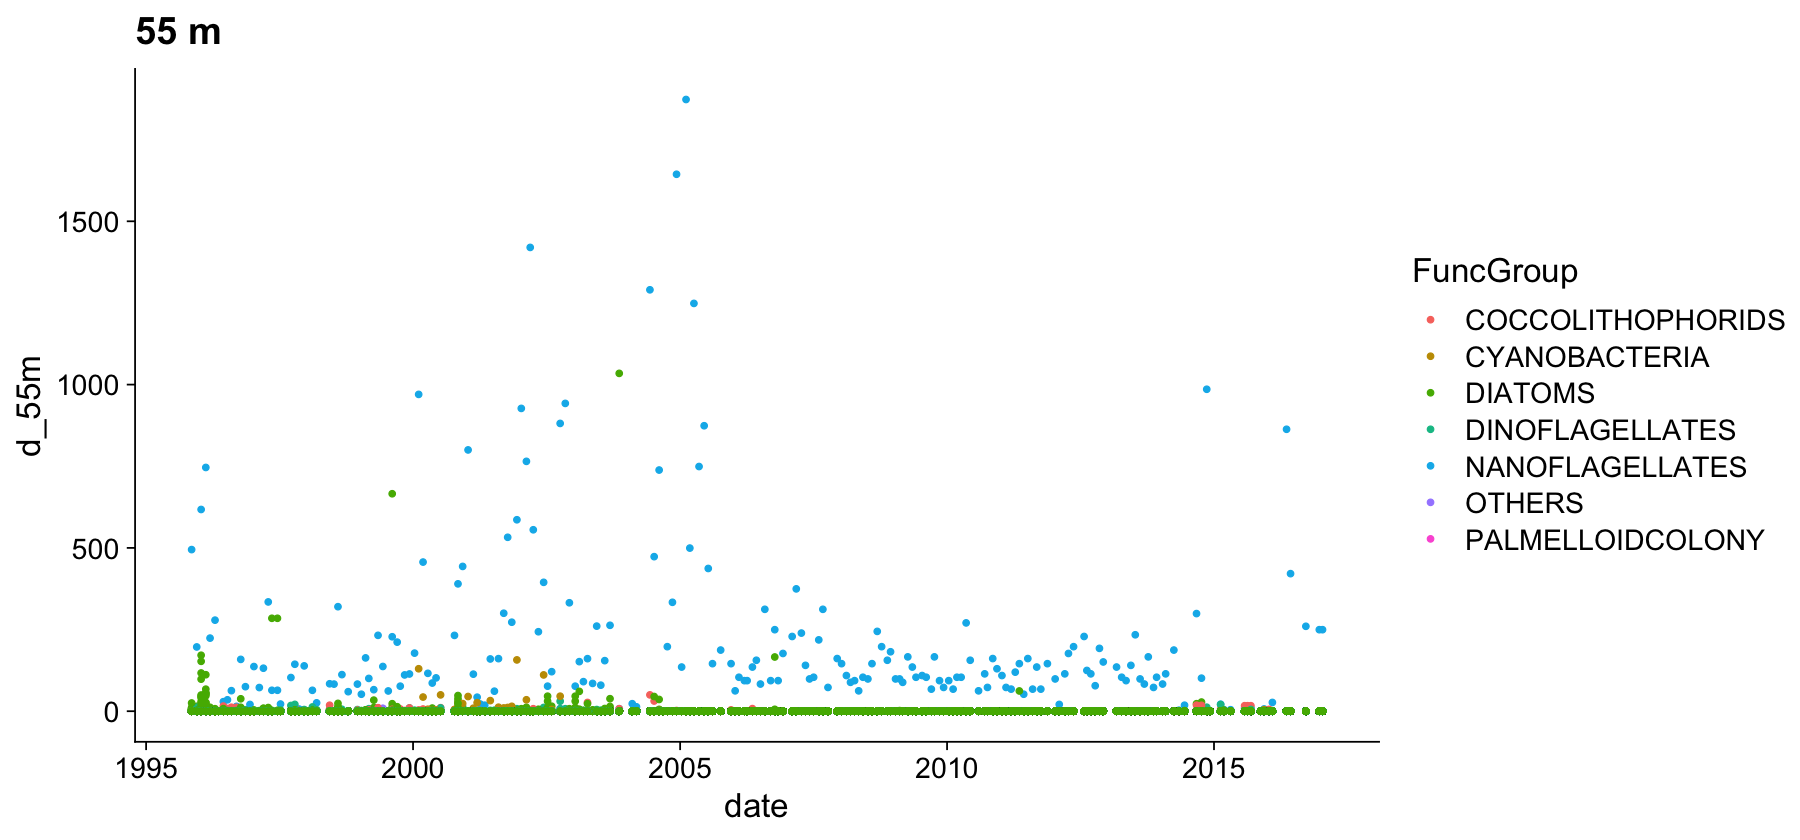

In [116]:
ggplot(data=ds_FG_cleaned, aes(x=date, y=d_1m, color=FuncGroup)) + geom_point() + theme_cowplot(font_size=20)+
ggtitle("1 m")

ggplot(data=ds_FG_cleaned, aes(x=date, y=d_7m, color=FuncGroup)) + geom_point() + theme_cowplot(font_size=20)+
ggtitle("7 m")

ggplot(data=ds_FG_cleaned, aes(x=date, y=d_15m, color=FuncGroup)) + geom_point() + theme_cowplot(font_size=20)+
ggtitle("15 m")

ggplot(data=ds_FG_cleaned, aes(x=date, y=d_25m, color=FuncGroup)) + geom_point() + theme_cowplot(font_size=20)+
ggtitle("25 m")

ggplot(data=ds_FG_cleaned, aes(x=date, y=d_35m, color=FuncGroup)) + geom_point() + theme_cowplot(font_size=20)+
ggtitle("35 m")

ggplot(data=ds_FG_cleaned, aes(x=date, y=d_55m, color=FuncGroup)) + geom_point() + theme_cowplot(font_size=20)+
ggtitle("55 m")

In [14]:
blob <- rbind(data.frame(val=ds_FG$d_1m, depth=1, date=ds_FG$date, AphiaID=ds_FG$AphiaID , FuncGroup=ds_FG$FuncGroup),
      data.frame(val=ds_FG$d_7m, depth=7, date=ds_FG$date, AphiaID=ds_FG$AphiaID, FuncGroup=ds_FG$FuncGroup),
      data.frame(val=ds_FG$d_15m, depth=15, date=ds_FG$date, AphiaID=ds_FG$AphiaID, FuncGroup=ds_FG$FuncGroup),
      data.frame(val=ds_FG$d_25m, depth=25, date=ds_FG$date, AphiaID=ds_FG$AphiaID, FuncGroup=ds_FG$FuncGroup),
      data.frame(val=ds_FG$d_55m, depth=55, date=ds_FG$date, AphiaID=ds_FG$AphiaID, FuncGroup=ds_FG$FuncGroup),
      data.frame(val=ds_FG$d_75m, depth=75, date=ds_FG$date, AphiaID=ds_FG$AphiaID, FuncGroup=ds_FG$FuncGroup),
      data.frame(val=ds_FG$d_100m, depth=100, date=ds_FG$date, AphiaID=ds_FG$AphiaID, FuncGroup=ds_FG$FuncGroup))

In [23]:
#blob

In [24]:
func_group_key = unique(blob[,c('AphiaID', 'FuncGroup')])

In [25]:
# Function to read specific functionial type from dataset

prepdataframe <- function(funcgroup='', datasource='blob'){
    if(datasource=='blob'){
    DF <- blob
    #print(names(DF))
    
    DF_FG <- DF %>%
     filter(FuncGroup == funcgroup)
    
    VarDF <- DF_FG %>%
      select(date, val, depth) %>%
      gather(key='key',value = "value", -date, -depth)
    #head(VarDF)
    }
    
    return(VarDF)
}

In [26]:
# Interpolate
interpolateDF <- function(DF,func='linear'){
    zz <- seq(0, 100, 1)
    
    if(func=='linear'){
        IntDF <- DF %>%
            group_by(date) %>%
            filter(sum(!is.na(value))>1) %>%
            do(data.frame(value_int = with(.,approx(depth, value, zz)), depth = zz)) 
        
        IntDF <- IntDF %>% 
              rename(
                value_int = value_int.y
                )
        IntDF$value_int.x <- NULL
        }
    
    return(IntDF)
}

In [27]:
#diatoms <- prepdataframe("DIATOMS")

In [28]:

getfuncgroupint <- function(funcgroup){
    
        fg_dat <- prepdataframe(funcgroup)

        fg_dat_int <- interpolateDF(fg_dat)

        fg_dat_sum <- fg_dat_int %>%
            group_by(date) %>%
            filter(depth<101) %>%
            filter(sum(is.na(value_int))<20) %>%
            summarize(#value_sum = sum(value_int, na.rm=TRUE), 
                      value_mean = mean(value_int, na.rm=TRUE),
                      #value_intgrtd = value_mean * 100,
                      #NAs = sum(is.na(value_int)), .groups="keep"
            )   

    return(fg_dat_sum)
}

In [29]:
defaultW <- getOption("warn")
options(warn = -1)


diatoms_sum <- getfuncgroupint("DIATOMS")

#dino_sum <- getfuncgroupint("DINOFLAGELLATES")

#cyano_sum <- getfuncgroupint("CYANOBACTERIA")

#nano_sum <- getfuncgroupint("NANOFLAGELLATES")

In [30]:
# check magnitude, use the same values as legacy papaer

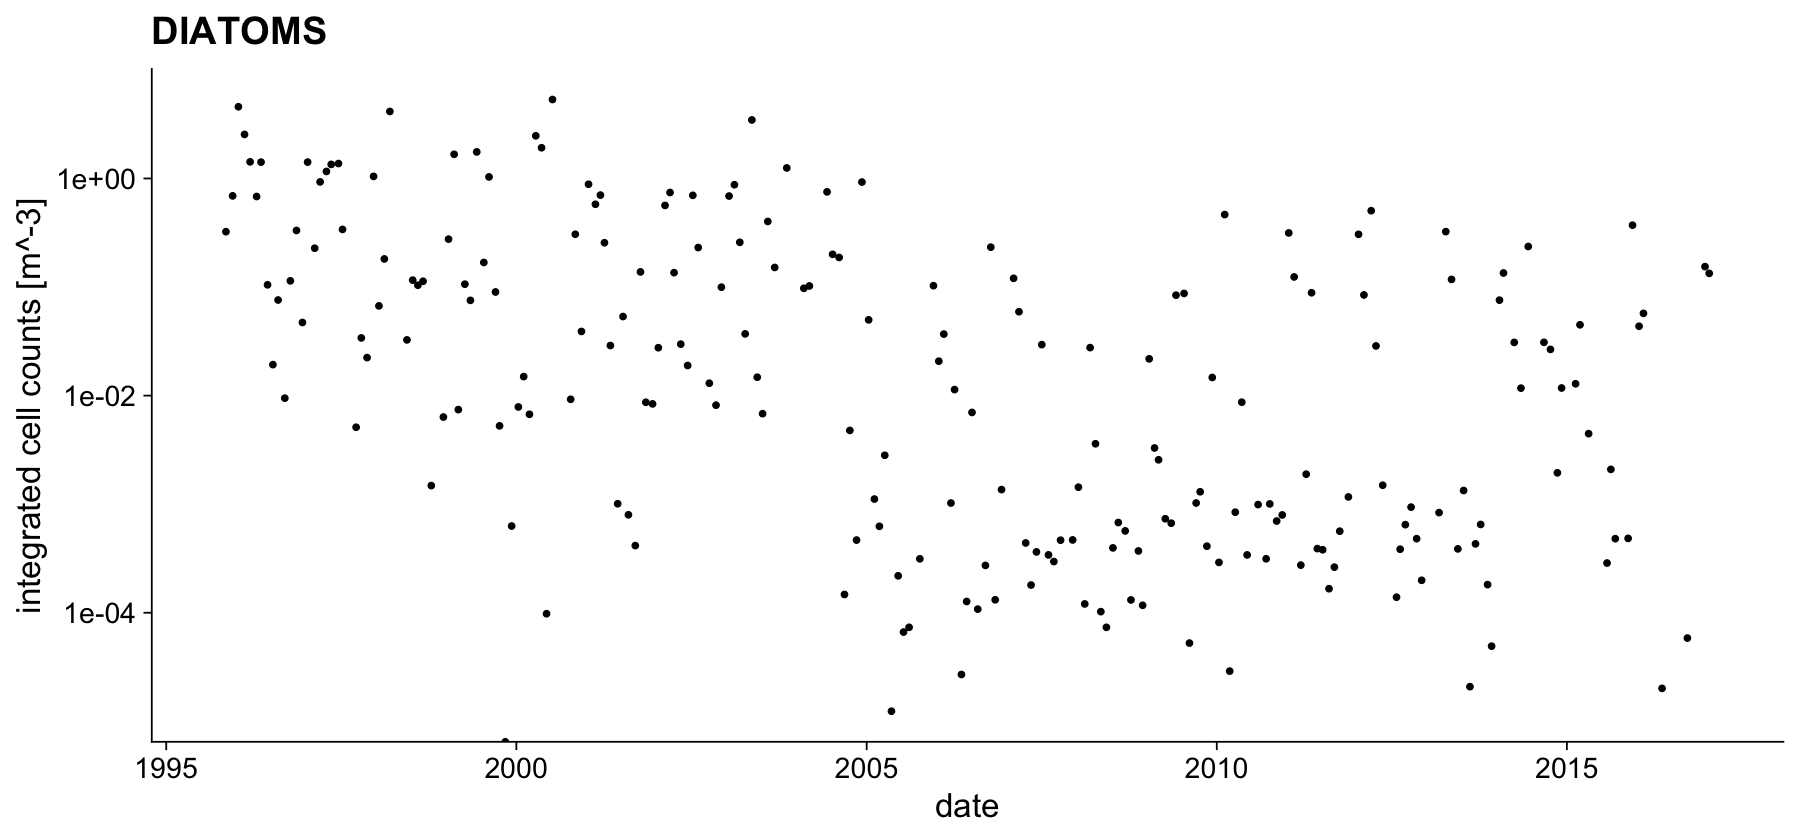

In [31]:
ggplot(data=diatoms_sum, aes(x=date, y=value_mean)) + geom_point() + theme_cowplot(font_size=20)+
 ggtitle("DIATOMS") + ylab("integrated cell counts [m^-3]") + scale_y_log10()

In [32]:
#diatoms_sum

In [33]:
FuncGroups = unique(AphiaID2FG$FuncGroup)

fgnum = length(FuncGroups)

# Create Dataframe of Integrated Counts per Func Group

In [34]:
fg_intmean_dat <- getfuncgroupint(FuncGroups[1])
names(fg_intmean_dat)[2] <- FuncGroups[1]

#print(head(fg_intmean_dat))
#print(names(fg_intmean_dat))

for (i in 2:fgnum){
    print(paste(i, "FuncGroup: ", FuncGroups[i]))
    fg_intmean_dat <- left_join(fg_intmean_dat, getfuncgroupint(FuncGroups[i]), by = "date")
    #print(head(fg_intmean_dat))
    #print(names(fg_intmean_dat))
    names(fg_intmean_dat)[1+i] <- FuncGroups[i]
}

[1] "2 FuncGroup:  DIATOMS"
[1] "3 FuncGroup:  DINOFLAGELLATES"
[1] "4 FuncGroup:  CYANOBACTERIA"
[1] "5 FuncGroup:  OTHERS"
[1] "6 FuncGroup:  NANOFLAGELLATES"


In [35]:
#write.csv(fg_intmean_dat, "IntegratedPhytoplanktonFuncGroupCounts.csv")

# GET PRESENCE PER CRUISE PER APHIA ID

In [36]:
# function to read specific aphia id identified from dataset

prepdataframe_APHIA <- function(aphia_id='', datasource='blob'){
    if(datasource=='blob'){
    DF <- blob
    #print(names(DF))
    
    DF_FG <- DF %>%
     filter(AphiaID == aphia_id)
    
    VarDF <- DF_FG %>%
      select(date, val, depth) %>%
      gather(key='key',value = "value", -date, -depth)
    #head(VarDF)
    }
    
    return(VarDF)
}

In [37]:
head(prepdataframe_APHIA(17657))

date                depth key value
1 2007-05-08 09:06:00 1     val 0    
2 2006-10-10 09:13:00 1     val 0    
3 2012-11-08 09:19:00 1     val 0    
4 2004-02-08 08:29:00 1     val 0    
5 2011-07-07 08:57:00 1     val 0    
6 2012-04-10 09:11:00 1     val 0

In [40]:
head(getAPHIAint(17657))

date                value_sum
1 1999-07-15 09:36:00 0.00     
2 1999-08-11 09:25:00 1.26     
3 2000-07-07 10:03:00 0.00     
4 2001-02-16 10:35:00 0.00     
5 2001-03-14 10:28:00 0.00     
6 2001-04-04 09:45:00 0.00

In [41]:
# get interpolated presences for specific AphiaID
getAPHIAint <- function(aphia_id){
    
        ap_dat <- prepdataframe_APHIA(aphia_id)

        ap_dat_int <- interpolateDF(ap_dat)

        ap_dat_sum <- ap_dat_int %>%
            group_by(date) %>%
            filter(depth<101) %>%
            filter(sum(is.na(value_int))<20) %>%
            summarize(value_sum = sum(value_int, na.rm=TRUE), 
                      #value_mean = mean(value_int, na.rm=TRUE),
                      #value_intgrtd = value_mean * 100,
                      #NAs = sum(is.na(value_int)), .groups="keep"
            )   

    return(ap_dat_sum)
}

In [42]:
AphiaIDs <- unique(blob[blob$AphiaID>1,]$AphiaID)

apnum = length(AphiaIDs)

In [43]:
ap_intmean_dat <- getAPHIAint(AphiaIDs[1])
names(ap_intmean_dat)[2] <- AphiaIDs[1]

#print(head(fg_intmean_dat))
#print(names(fg_intmean_dat))

for (i in 2:apnum){
    #print(paste(i, "AphiaID: ", AphiaIDs[i]))
    ap_intmean_dat <- left_join(ap_intmean_dat, getAPHIAint(AphiaIDs[i]), by = "date")
    #print(head(fg_intmean_dat))
    #print(names(fg_intmean_dat))
    names(ap_intmean_dat)[1+i] <- AphiaIDs[i]
}

In [44]:
#ap_intmean_dat

In [45]:
spec_ric_dat <- ap_intmean_dat %>%
    pivot_longer(!date, names_to='AphiaID', values_to='values_sum' ) %>%
    group_by(date) %>%
    mutate(presence = values_sum > 0 & !is.na(values_sum)) %>%
    summarize(species_richness=sum(presence))

In [46]:
#write.csv(spec_ric_dat, "IntegratedPhytoplanktonSpeciesRichnessEstimate.csv")

In [48]:
#spec_ric_dat

# Try to get richness per func group

In [64]:
for (i in 100:101){
    a = func_group_key[func_group_key$AphiaID==Aphia_dailysum_dat$AphiaID[i],]$FuncGroup
    print(a)
    }

[1] "DINOFLAGELLATES"
[1] "DINOFLAGELLATES"


In [73]:
Aphia_dailysum_dat <- ap_intmean_dat %>%
    pivot_longer(!date, names_to='AphiaID', values_to='values_sum' ) %>%
    group_by(date) #%>%
    #mutate(across(func_group_key$FuncGroup==AphiaID ))#func_group_key[func_group_key$AphiaID==AphiaID,]$FuncGroup) #%>%
    #summarize(species_richness=sum(presence))

In [83]:
head(Aphia_dailysum_dat)

date                AphiaID values_sum
1 1995-11-08 07:36:00 801      0        
2 1995-11-08 07:36:00 17657   NA        
3 1995-11-08 07:36:00 106283  NA        
4 1995-11-08 07:36:00 106285  NA        
5 1995-11-08 07:36:00 106289  NA        
6 1995-11-08 07:36:00 106314  NA

In [85]:
FuncAphia_dat <- Aphia_dailysum_dat %>%
    group_by(AphiaID) %>%
    mutate(FuncGroup = func_group_key[func_group_key$AphiaID==AphiaID,]$FuncGroup) %>%
    ungroup() 

In [91]:
FuncGroup_SpeciesRichness <- FuncAphia_dat %>%
    group_by(date, FuncGroup) %>%
    mutate(presence = values_sum > 0 & !is.na(values_sum)) %>%
    summarize(species_richness=sum(presence)) %>%
    pivot_wider(names_from = FuncGroup, values_from = species_richness)

`summarise()` has grouped output by 'date'. You can override using the `.groups` argument.



In [92]:
write.csv(FuncGroup_SpeciesRichness,"IntegratedPhytoplanktonFuncGroupSpeciesRichness.csv")